In [29]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, classification_report, f1_score, recall_score, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC

# Feature engineering transformers
class FeatureEngineeringPipeline:
    def __init__(self):
        self.med_columns = [
            'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
            'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
            'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'insulin',
            'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
            'metformin-pioglitazone'
        ]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = X.copy()
        
        # Medication features
        data['on_multiple_meds'] = (data['num_medications'] >= 3).astype(int)
        data['med_changes_total'] = data[self.med_columns].apply(
            lambda x: ((x == 'Up') | (x == 'Down')).sum(), axis=1)
        data['insulin_binary'] = (data['insulin'] != 'No').astype(int)
    

        # Hospital utilization features
        data['total_visits'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']
        data['repeated_emergency'] = (data['number_emergency'] > 1).astype(int)
        data['all_usage'] = ((data['number_outpatient'] > 0) & 
        (data['number_emergency'] > 0) & 
        (data['number_inpatient'] > 0)).astype(int)
        
        
        # Risk features
        age_risk_map = {
        '[0-10)': 1, '[10-20)': 1, '[20-30)': 1,
        '[30-40)': 2, '[40-50)': 2, '[50-60)': 3,
        '[60-70)': 4, '[70-80)': 5, '[80-90)': 5, '[90-100)': 5}
        data['age_risk'] = data['age'].map(age_risk_map)
        data['risk_score'] = (
        data['age_risk'] + 
        data['number_inpatient'] * 2 + 
        data['number_emergency'] * 1.5 +
        data['num_medications'] * 1.2)
        
        # Admission features
        data['is_emergency'] = (data['admission_type'] == 'Urgent/Emergency').astype(int)
        data = data.drop(columns=['patient_nbr'])
        return data
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

def convert_categorical_columns(df):
    """Convert object columns to categorical dtype"""
    df_typed = df.copy()
    
    # List of columns that should be categorical
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    
    # Convert object columns to categorical
    for col in categorical_cols:
        df_typed[col] = df_typed[col].astype('category')
    
    return df_typed

def prepare_data(df):
    """Prepare data for modeling"""
    # Fix data types
    df = convert_categorical_columns(df)
    
    # Convert target to binary
    df["readmitted_binary"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)
    
    # Split data
    X = df.drop(columns=["readmitted", "readmitted_binary"])
    y = df["readmitted_binary"]
    
    # Apply feature engineering
    feature_pipeline = FeatureEngineeringPipeline()
    X_enriched = feature_pipeline.transform(X)
    
    # Identify categorical features
    cat_columns = X_enriched.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_columns = X_enriched.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Split data into train, calibration, and test sets: 
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_enriched, y, random_state=1984, stratify=y, train_size=0.7  # Increase train size to 70%
    )

    X_calib, X_test, y_calib, y_test = train_test_split(
        X_temp, y_temp, random_state=1984, stratify=y_temp, train_size=0.5  # 15% Calibration, 15% Test
    )
    
    return df, X_enriched, y, X_train, X_calib, X_test, y_train, y_calib, y_test, cat_columns, numerical_columns

def create_smote_balanced_data(X_train, y_train, cat_columns):
    """Create SMOTE-balanced version of the training data"""
    # Apply SMOTENC to training data
    cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]
    smote = SMOTENC(sampling_strategy=0.5, random_state=42, categorical_features=cat_indices)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    return X_train_balanced, y_train_balanced

# CatBoost Models with Custom Calibration
class CalibratedCatBoost:
    def __init__(self, base_model, calibrator, cat_features):
        self.base_model = base_model
        self.calibrator = calibrator
        self.cat_features = cat_features
        
    def predict_proba(self, X):
        # Get raw predictions
        pool = Pool(data=X, cat_features=self.cat_features)
        raw_probs = self.base_model.predict_proba(pool)
        
        # Calibrate positive class probabilities
        calibrated_pos_probs = self.calibrator.transform(raw_probs[:, 1])
        
        # Return calibrated probabilities for both classes
        calibrated_probs = np.column_stack([1 - calibrated_pos_probs, calibrated_pos_probs])
        return calibrated_probs

def train_catboost_smote(X_train_balanced, y_train_balanced, cat_columns, X_calib, y_calib):
    """Train CatBoost model with SMOTE-balanced data and calibration"""
    # CatBoost best parameters
    catboost_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        loss_function='Logloss',
        eval_metric='F1',
        random_seed=1984,
        verbose=100
    )
    
    # Train CatBoost with SMOTE-balanced data
    print("Training CatBoost with SMOTE...")
    train_pool = Pool(data=X_train_balanced, label=y_train_balanced, cat_features=cat_columns)
    catboost_model.fit(train_pool)
    
    # Calibrate the model
    print("Calibrating CatBoost with SMOTE...")
    
    # Get predictions on calibration data
    calib_pool = Pool(data=X_calib, cat_features=cat_columns)
    calib_preds = catboost_model.predict_proba(calib_pool)[:, 1]
    
    # Create and train an isotonic regression model
    isotonic = IsotonicRegression(out_of_bounds='clip')
    isotonic.fit(calib_preds, y_calib)
    
    # Return the calibrated model
    return CalibratedCatBoost(catboost_model, isotonic, cat_columns)

def train_catboost_class_weights(X_train, y_train, cat_columns, X_calib, y_calib):
    """Train CatBoost model with class weights and calibration"""
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count
    
    # CatBoost with class weights
    catboost_cw_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights=[1, scale_pos_weight],  # [negative_class_weight, positive_class_weight]
        random_seed=1984,
        verbose=100
    )
    
    # Train CatBoost with class weights
    print("Training CatBoost with class weights...")
    train_pool_cw = Pool(data=X_train, label=y_train, cat_features=cat_columns)
    catboost_cw_model.fit(train_pool_cw)
    
    # Calibrate the model
    print("Calibrating CatBoost with class weights...")
    
    # Get predictions on calibration data
    calib_pool = Pool(data=X_calib, cat_features=cat_columns)
    calib_preds = catboost_cw_model.predict_proba(calib_pool)[:, 1]
    
    # Create and train an isotonic regression model
    isotonic = IsotonicRegression(out_of_bounds='clip')
    isotonic.fit(calib_preds, y_calib)
    
    # Return the calibrated model
    return CalibratedCatBoost(catboost_cw_model, isotonic, cat_columns)

# LightGBM Models
def train_lightgbm_smote(X_train_balanced, y_train_balanced, cat_columns, X_calib, y_calib):
    """Train LightGBM model with SMOTE-balanced data"""
    # LightGBM best parameters
    lightgbm_model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=1984
    )
    
    # Train LightGBM with SMOTE-balanced data
    print("Training LightGBM with SMOTE...")
    cat_indices_balanced = [X_train_balanced.columns.get_loc(col) for col in cat_columns]
    lightgbm_model.fit(X_train_balanced, y_train_balanced, categorical_feature=cat_indices_balanced)
    
    # Calibrate the model
    print("Calibrating LightGBM with SMOTE...")
    calibrated_lightgbm_smote = CalibratedClassifierCV(
        clone(lightgbm_model), 
        method='isotonic', 
        cv=5
    )
    calibrated_lightgbm_smote.fit(X_calib, y_calib)

    return calibrated_lightgbm_smote

def train_lightgbm_class_weights(X_train, y_train, cat_columns, X_calib, y_calib):
    """Train LightGBM model with class weights and calibration"""
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count
    
    # LightGBM with class weights
    lightgbm_cw_model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        scale_pos_weight=scale_pos_weight,
        random_state=1984
    )
    
    # Train LightGBM with class weights
    print("Training LightGBM with class weights...")
    cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]
    lightgbm_cw_model.fit(X_train, y_train, categorical_feature=cat_indices)
    
    # Calibrate the model
    print("Calibrating LightGBM with class weights...")
    calibrated_lightgbm = CalibratedClassifierCV(
        clone(lightgbm_cw_model),
        method='isotonic',
        cv=5
    )
    calibrated_lightgbm.fit(X_calib, y_calib)
    
    return calibrated_lightgbm

# XGBoost Models
def train_xgboost_smote(X_train_balanced, y_train_balanced, cat_columns, numerical_columns, X_calib, y_calib):
    """Train XGBoost model with SMOTE-balanced data"""
    # Preprocessor for XGBoost
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns),
            ('num', StandardScaler(), numerical_columns)
        ])
    
    # Define XGBoost best parameters (from your original code)
    best_params = {
        'n_estimators': 166,
        'learning_rate': 0.07656863414575588,
        'max_depth': 3,
        'subsample': 0.8434226991527956,
        'colsample_bytree': 0.5887056094127622
    }
    
    # XGBoost pipeline without class weights
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('xgboost', XGBClassifier(random_state=1984, **best_params))
    ])
    
    # Train XGBoost with SMOTE-balanced data
    print("Training XGBoost with SMOTE...")
    xgb_pipeline.fit(X_train_balanced, y_train_balanced)

    # Calibrate the model
    print("Calibrating XGBoost with SMOTE...")
    calibrated_xgb_smote = CalibratedClassifierCV(
        clone(xgb_pipeline),
        method='isotonic',
        cv=5
    )
    calibrated_xgb_smote.fit(X_calib, y_calib)
    
    return calibrated_xgb_smote

def plot_calibration_curves(y_test, probabilities, selected_models=None, n_bins=10, figsize=(10, 8)):
    """
    Plot calibration curves for the trained models.
    
    Parameters:
    -----------
    y_test : array-like
        True binary labels
    probabilities : dict
        Dictionary of probabilities for each model
    selected_models : list or None
        List of model names to include in the plot. If None, use all models.
    n_bins : int, default=10
        Number of bins for the calibration curve
    figsize : tuple, default=(10, 8)
        Figure size
    """
    import matplotlib.pyplot as plt
    
    if selected_models is None:
        selected_models = list(probabilities.keys())
    
    plt.figure(figsize=figsize)
    
    # Plot perfectly calibrated line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    
    # Define a list of colors for different models
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Plot each model's calibration curve
    for i, model_name in enumerate(selected_models):
        if model_name in probabilities:
            prob_pos = probabilities[model_name]
            fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=n_bins)
            
            # Plot the calibration curve
            plt.plot(mean_predicted_value, fraction_of_positives, 's-', color=colors[i % len(colors)],
                     label=f'{model_name}')
    
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve for Hospital Readmission Models')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Add diagonal grid lines
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    return plt

def analyze_calibration_metrics(y_test, probabilities, selected_models=None):
    """Calculate calibration metrics for each model"""
    from sklearn.metrics import brier_score_loss, log_loss
    
    if selected_models is None:
        selected_models = list(probabilities.keys())
    
    # Create a dataframe to store results
    results = []
    
    for model_name in selected_models:
        if model_name in probabilities:
            brier = brier_score_loss(y_test, probabilities[model_name])
            logloss = log_loss(y_test, probabilities[model_name])
            results.append({
                'Model': model_name,
                'Brier Score': brier,
                'Log Loss': logloss
            })
    
    return pd.DataFrame(results)

def train_xgboost_class_weights(X_train, y_train, cat_columns, numerical_columns, X_calib, y_calib):
    """Train XGBoost model with class weights and calibration"""
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count
    
    # Preprocessor for XGBoost
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns),
            ('num', StandardScaler(), numerical_columns)
        ])
    
    # Define XGBoost best parameters (from your original code)
    best_params = {
        'n_estimators': 166,
        'learning_rate': 0.07656863414575588,
        'max_depth': 3,
        'subsample': 0.8434226991527956,
        'colsample_bytree': 0.5887056094127622,
        'scale_pos_weight': scale_pos_weight
    }
    
    # XGBoost pipeline with class weights
    xgb_cw_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('xgboost', XGBClassifier(random_state=1984, **best_params))
    ])
    
    # Train XGBoost with class weights
    print("Training XGBoost with class weights...")
    xgb_cw_pipeline.fit(X_train, y_train)
    
    # Calibrate the model
    print("Calibrating XGBoost with class weights...")
    calibrated_xgb = CalibratedClassifierCV(
        clone(xgb_cw_pipeline),
        method='isotonic',
        cv=5
    )
    calibrated_xgb.fit(X_calib, y_calib)
    
    return calibrated_xgb

def train_xgb_uncalib(X_train, y_train, cat_columns, numerical_columns):
    """Train XGBoost model with class weights and calibration"""
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count
    
    # Preprocessor for XGBoost
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns),
            ('num', StandardScaler(), numerical_columns)
        ])
    
    # Define XGBoost best parameters (from your original code)
    best_params = {
        'n_estimators': 166,
        'learning_rate': 0.07656863414575588,
        'max_depth': 3,
        'subsample': 0.8434226991527956,
        'colsample_bytree': 0.5887056094127622,
        'scale_pos_weight': scale_pos_weight
    }
    
    # XGBoost pipeline with class weights
    xgb_cw_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('xgboost', XGBClassifier(random_state=1984, **best_params))
    ])
    
    # Train XGBoost with class weights
    print("Training XGBoost with class weights...")
    xgb_cw_pipeline.fit(X_train, y_train)
    
    return xgb_cw_pipeline


# Random Forest Models
def train_randomforest_smote(X_train_balanced, y_train_balanced, cat_columns, X_calib, y_calib):
    """Train RandomForest model with SMOTE-balanced data and calibration"""
    # One-hot encode categorical features
    X_train_rf = pd.get_dummies(X_train_balanced, columns=cat_columns, drop_first=False)
    X_calib_rf = pd.get_dummies(X_calib, columns=cat_columns, drop_first=False)

    # Ensure columns match
    train_cols = set(X_train_rf.columns)
    calib_cols = set(X_calib_rf.columns)

    # Add missing columns
    for col in train_cols - calib_cols:
        X_calib_rf[col] = 0

    # RandomForest best parameters
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=1984,
        n_jobs=-1
    )

    # Train RandomForest with SMOTE-balanced data
    print("Training RandomForest with SMOTE...")
    rf_model.fit(X_train_rf, y_train_balanced)

    # Calibrate the model
    print("Calibrating RandomForest with SMOTE...")
    calibrated_rf = CalibratedClassifierCV(
        clone(rf_model),
        method='isotonic',
        cv=5
    )
    calibrated_rf.fit(X_calib_rf, y_calib)

    return calibrated_rf, X_train_rf.columns.tolist()

def train_randomforest_class_weights(X_train, y_train, cat_columns, X_calib, y_calib):
    """Train RandomForest model with class weights and calibration"""
    # First one-hot encode categorical features
    X_train_rf = pd.get_dummies(X_train, columns=cat_columns, drop_first=False)
    X_calib_rf = pd.get_dummies(X_calib, columns=cat_columns, drop_first=False)
    
    # Ensure columns match
    train_cols = set(X_train_rf.columns)
    calib_cols = set(X_calib_rf.columns)
    
    # Add missing columns
    for col in train_cols - calib_cols:
        X_calib_rf[col] = 0
    
    # RandomForest with class weights
    rf_cw_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=1984,
        n_jobs=-1
    )
    
    # Train RandomForest with class weights
    print("Training RandomForest with class weights...")
    rf_cw_model.fit(X_train_rf, y_train)
    
    # Calibrate the model
    print("Calibrating RandomForest with class weights...")
    calibrated_rf = CalibratedClassifierCV(
        clone(rf_cw_model),
        method='isotonic',
        cv=5
    )
    calibrated_rf.fit(X_calib_rf, y_calib)
    
    return calibrated_rf, X_train_rf.columns.tolist()  # Return column names for testing

# Logistic Regression Models
def train_logistic_regression_smote(X_train_balanced, y_train_balanced, cat_columns, numerical_columns, X_calib, y_calib):
    """Train LogisticRegression model with SMOTE-balanced data and apply calibration"""
    # One-hot encode categorical features
    X_train_lr = pd.get_dummies(X_train_balanced, columns=cat_columns, drop_first=False)
    X_calib_lr = pd.get_dummies(X_calib, columns=cat_columns, drop_first=False)

    # Ensure columns match
    train_cols = set(X_train_lr.columns)
    calib_cols = set(X_calib_lr.columns)

    # Add missing columns
    for col in train_cols - calib_cols:
        X_calib_lr[col] = 0
    for col in calib_cols - train_cols:
        X_train_lr[col] = 0

    # Standardize numerical features
    scaler = StandardScaler()
    num_cols = [col for col in X_train_lr.columns if col in numerical_columns]
    X_train_lr[num_cols] = scaler.fit_transform(X_train_lr[num_cols])
    X_calib_lr[num_cols] = scaler.transform(X_calib_lr[num_cols])

    # LogisticRegression without class weights
    lr_model = LogisticRegression(
        C=10,
        solver='liblinear',
        penalty='l2',
        max_iter=100,
        random_state=1984
    )

    # Train LogisticRegression with SMOTE-balanced data
    print("Training LogisticRegression with SMOTE...")
    lr_model.fit(X_train_lr, y_train_balanced)

    # Calibrate the model
    print("Calibrating LogisticRegression with SMOTE...")
    calibrated_lr_smote = CalibratedClassifierCV(
        clone(lr_model),
        method='isotonic',
        cv=5
    )
    calibrated_lr_smote.fit(X_calib_lr, y_calib)

    return calibrated_lr_smote, X_train_lr.columns.tolist(), scaler

def train_logistic_regression_class_weights(X_train, y_train, cat_columns, numerical_columns, X_calib, y_calib):
    """Train LogisticRegression model with class weights and calibration"""
    # One-hot encode categorical features
    X_train_lr = pd.get_dummies(X_train, columns=cat_columns, drop_first=False)
    X_calib_lr = pd.get_dummies(X_calib, columns=cat_columns, drop_first=False)
    
    # Ensure columns match
    train_cols = set(X_train_lr.columns)
    calib_cols = set(X_calib_lr.columns)
    
    # Add missing columns
    for col in train_cols - calib_cols:
        X_calib_lr[col] = 0
    for col in calib_cols - train_cols:
        X_train_lr[col] = 0
    
    # Standardize numerical features
    scaler = StandardScaler()
    num_cols = [col for col in X_train_lr.columns if col in numerical_columns]
    X_train_lr[num_cols] = scaler.fit_transform(X_train_lr[num_cols])
    X_calib_lr[num_cols] = scaler.transform(X_calib_lr[num_cols])
    
    # LogisticRegression with class weights
    lr_cw_model = LogisticRegression(
        C=1.0,
        class_weight='balanced',
        solver='saga',
        penalty='l1',
        max_iter=100,
        random_state=1984
    )
    
    # Train LogisticRegression with class weights
    print("Training LogisticRegression with class weights...")
    lr_cw_model.fit(X_train_lr, y_train)
    
    # Calibrate the model
    print("Calibrating LogisticRegression with class weights...")
    calibrated_lr = CalibratedClassifierCV(
        clone(lr_cw_model),
        method='isotonic',
        cv=5
    )
    calibrated_lr.fit(X_calib_lr, y_calib)
    
    return calibrated_lr, X_train_lr.columns.tolist(), scaler  # Return model, columns, and scaler

def get_model_predictions(models, X_test, y_test, cat_columns, numerical_columns, model_metadata):
    """Get probability predictions from all models"""
    probabilities = {}
    
    # Prepare test data for each model
    for model_name, model_info in models.items():
        model = model_info['model']
        
        if "CatBoost" in model_name:
            # Using our custom CalibratedCatBoost class
            probabilities[model_name] = model.predict_proba(X_test)[:, 1]
        
        elif "XGBoost" in model_name:
            # XGBoost pipelines handle preprocessing internally
            probabilities[model_name] = model.predict_proba(X_test)[:, 1]
        
        elif "LightGBM" in model_name:
            # Use raw X_test for LightGBM
            probabilities[model_name] = model.predict_proba(X_test)[:, 1]
        
        elif "RandomForest" in model_name:
            # One-hot encode for RandomForest
            rf_columns = model_metadata[model_name]['columns']
            X_test_rf = pd.get_dummies(X_test, columns=cat_columns, drop_first=False)
            
            # Ensure columns match
            for col in rf_columns:
                if col not in X_test_rf.columns:
                    X_test_rf[col] = 0
            X_test_rf = X_test_rf[rf_columns]  # Reorder columns
            
            probabilities[model_name] = model.predict_proba(X_test_rf)[:, 1]
        
        elif "LogisticRegression" in model_name:
            # One-hot encode and scale for LogisticRegression
            lr_columns = model_metadata[model_name]['columns']
            scaler = model_metadata[model_name]['scaler']
            
            X_test_lr = pd.get_dummies(X_test, columns=cat_columns, drop_first=False)
            
            # Ensure columns match
            for col in lr_columns:
                if col not in X_test_lr.columns:
                    X_test_lr[col] = 0
            X_test_lr = X_test_lr[lr_columns]  # Reorder columns
            
            # Scale numerical features
            num_cols = [col for col in X_test_lr.columns if col in numerical_columns]
            X_test_lr[num_cols] = scaler.transform(X_test_lr[num_cols])
            
            probabilities[model_name] = model.predict_proba(X_test_lr)[:, 1]
    
    return probabilities

def find_best_threshold(y_true, y_pred_proba):
    """Find optimal threshold for F2 score based on probabilities"""
    max_f2 = -float('inf')
    max_f2_threshold = -float('inf')
    
    # Check thresholds to find the best F2 score
    for threshold in np.linspace(0, 1, 100):
        y_pred = (y_pred_proba > threshold).astype(int)  # Apply threshold
        f2 = fbeta_score(y_true, y_pred, beta=2, pos_label=1)
        if f2 > max_f2:
            max_f2_threshold = threshold
            max_f2 = f2
    
    return max_f2_threshold, max_f2

def calculate_financial_impact(y_true, y_pred_proba, threshold,
                              cost_per_readmission=16300,
                              cost_per_intervention=2500,
                              intervention_effectiveness=0.30):
    """Calculate financial impact of predictions"""
    
    # Apply threshold to get binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Confusion matrix counts
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True positives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False positives
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False negatives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True negatives
    
    # Calculate costs
    # Baseline: no model, no intervention
    baseline_readmission_cost = np.sum(y_true) * cost_per_readmission
    
    # With model-driven interventions
    intervention_costs = (tp + fp) * cost_per_intervention
    prevented_readmissions = tp * intervention_effectiveness
    remaining_readmission_costs = (tp - prevented_readmissions + fn) * cost_per_readmission
    
    # Total costs
    total_cost = intervention_costs + remaining_readmission_costs
    savings = baseline_readmission_cost - total_cost
    roi = (savings / intervention_costs) * 100 if intervention_costs > 0 else 0
    
    return {
        'Baseline Cost': baseline_readmission_cost,
        'Total Cost': total_cost,
        'Savings': savings,
        'ROI (%)': roi,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Interventions': tp + fp,
        'Prevented Readmissions': prevented_readmissions
    }

def find_financial_optimal_threshold(y_true, y_pred_proba, 
                                    cost_per_readmission=16300,
                                    cost_per_intervention=2500,
                                    intervention_effectiveness=0.30):
    """Find threshold that maximizes financial benefit"""
    
    best_threshold = 0
    max_savings = float('-inf')
    
    # Test thresholds
    for threshold in np.linspace(0.01, 0.99, 99):
        results = calculate_financial_impact(
            y_true, y_pred_proba, threshold,
            cost_per_readmission, cost_per_intervention, intervention_effectiveness
        )
        
        if results['Savings'] > max_savings:
            max_savings = results['Savings']
            best_threshold = threshold
            best_results = results
    
    return best_threshold, best_results

def evaluate_models_with_thresholds(probabilities, y_test):
    """Evaluate models using optimal thresholds for both F2 and financial impact"""
    metrics = {}
    
    # First calculate F2-optimal thresholds and metrics
    for model_name, y_proba in probabilities.items():
        # Find optimal threshold for F2
        f2_threshold, max_f2 = find_best_threshold(y_test, y_proba)
        
        # Apply threshold
        y_pred = (y_proba > f2_threshold).astype(int)
        
        # Calculate metrics
        metrics[model_name] = {
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'F2': max_f2,
            'F2 Threshold': f2_threshold
        }
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

def calculate_financial_impact_for_models(probabilities, y_test):
    """Calculate financial impact metrics for all models"""
    financial_metrics = {}
    
    for model_name, y_proba in probabilities.items():
        # Find financially optimal threshold
        financial_threshold, financial_results = find_financial_optimal_threshold(
            y_test, y_proba,
            cost_per_readmission=16300,
            cost_per_intervention=2500,
            intervention_effectiveness=0.30
        )
        
        # Store financial metrics
        financial_metrics[model_name] = {
            'Financial Threshold': financial_threshold,
            'Savings ($)': financial_results['Savings'],
            'ROI (%)': financial_results['ROI (%)'],
            'Interventions': financial_results['Interventions'],
            'Prevented Readmissions': financial_results['Prevented Readmissions'],
            'TP': financial_results['TP'],
            'FP': financial_results['FP'],
            'TN': financial_results['TN'],
            'FN': financial_results['FN']
        }
    
    # Convert to DataFrame
    financial_df = pd.DataFrame(financial_metrics)
    
    return financial_df

def run_comparison():
    """Run the complete comparison pipeline"""
    # Load data
    print("Loading data...")
    df = pd.read_parquet('cleaned_hospital_readmission.parquet')
    
    # Prepare data
    print("Preparing data...")
    df, X_enriched, y, X_train, X_calib, X_test, y_train, y_calib, y_test, cat_columns, numerical_columns = prepare_data(df)
    
    # Create SMOTE-balanced version of training data
    X_train_balanced, y_train_balanced = create_smote_balanced_data(X_train, y_train, cat_columns)
    
    # Train models with different approaches
    print("Training models...")
    
    # Dictionary to store model metadata
    model_metadata = {}
    
    # CatBoost models (now with custom calibration)
    catboost_smote = train_catboost_smote(X_train_balanced, y_train_balanced, cat_columns, X_calib, y_calib)
    catboost_cw = train_catboost_class_weights(X_train, y_train, cat_columns, X_calib, y_calib)
    
    # LightGBM models
    lightgbm_smote = train_lightgbm_smote(X_train_balanced, y_train_balanced, cat_columns, X_calib, y_calib)
    lightgbm_cw = train_lightgbm_class_weights(X_train, y_train, cat_columns, X_calib, y_calib)
    
    # XGBoost models
    xgboost_smote = train_xgboost_smote(X_train_balanced, y_train_balanced, cat_columns, numerical_columns, X_calib, y_calib)
    xgboost_cw = train_xgboost_class_weights(X_train, y_train, cat_columns, numerical_columns, X_calib, y_calib)
    xgboost_uncalib = train_xgb_uncalib(X_train, y_train, cat_columns, numerical_columns)
    # RandomForest models
    rf_smote, rf_smote_columns = train_randomforest_smote(X_train_balanced, y_train_balanced, cat_columns, X_calib, y_calib)
    rf_cw, rf_cw_columns = train_randomforest_class_weights(X_train, y_train, cat_columns, X_calib, y_calib)
    
    # Add RandomForest columns to metadata
    model_metadata['RandomForest (SMOTE)'] = {'columns': rf_smote_columns}
    model_metadata['RandomForest (Class Weights)'] = {'columns': rf_cw_columns}
    
    # LogisticRegression models
    lr_smote, lr_smote_columns, lr_smote_scaler = train_logistic_regression_smote(
        X_train_balanced, y_train_balanced, cat_columns, numerical_columns, X_calib, y_calib
    )
    lr_cw, lr_cw_columns, lr_cw_scaler = train_logistic_regression_class_weights(
        X_train, y_train, cat_columns, numerical_columns, X_calib, y_calib
    )
    
    # Add LogisticRegression metadata
    model_metadata['LogisticRegression (SMOTE)'] = {
        'columns': lr_smote_columns,
        'scaler': lr_smote_scaler
    }
    model_metadata['LogisticRegression (Class Weights)'] = {
        'columns': lr_cw_columns,
        'scaler': lr_cw_scaler
    }
    
    # Store models in a dictionary with their metadata
    models = {
        'CatBoost (SMOTE)': {'model': catboost_smote},
        'CatBoost (Class Weights)': {'model': catboost_cw},
        'LightGBM (SMOTE)': {'model': lightgbm_smote},
        'LightGBM (Class Weights)': {'model': lightgbm_cw},
        'XGBoost (SMOTE)': {'model': xgboost_smote},
        'XGBoost (Class Weights)': {'model': xgboost_cw},
        'RandomForest (SMOTE)': {'model': rf_smote},
        'RandomForest (Class Weights)': {'model': rf_cw},
        'LogisticRegression (SMOTE)': {'model': lr_smote},
        'LogisticRegression (Class Weights)': {'model': lr_cw}
    }
    
    # Get predictions from all models
    print("Getting model predictions...")
    probabilities = get_model_predictions(models, X_test, y_test, cat_columns, numerical_columns, model_metadata)
    
    # First evaluate with performance metrics (without financial considerations)
    print("\n--- Performance Evaluation ---")
    metrics_df = evaluate_models_with_thresholds(probabilities, y_test)
    print(metrics_df)
    
    # Now apply financial impact analysis
    print("\n--- Financial Impact Analysis ---")
    financial_df = calculate_financial_impact_for_models(probabilities, y_test)
    print(financial_df)
    
    # Compare F2 vs Financial thresholds
    print("\n--- Threshold Comparison ---")
    threshold_comparison = pd.DataFrame({
        'F2 Threshold': metrics_df.loc['F2 Threshold'],
        'Financial Threshold': financial_df.loc['Financial Threshold'],
        'F2 Score': metrics_df.loc['F2'],
        'Financial Savings ($)': financial_df.loc['Savings ($)']
    })
    print(threshold_comparison)
    
    # Rank models by F2 score and financial savings
    print("\n--- Model Rankings ---")
    f2_ranking = metrics_df.loc['F2'].sort_values(ascending=False)
    financial_ranking = financial_df.loc['Savings ($)'].sort_values(ascending=False)
    
    print("By F2 Score:")
    for i, (model, score) in enumerate(f2_ranking.items(), 1):
        print(f"{i}. {model}: {score:.4f}")
    
    print("\nBy Financial Savings:")
    for i, (model, savings) in enumerate(financial_ranking.items(), 1):
        print(f"{i}. {model}: ${savings:,.2f}")
        
    return df, X_enriched, X_train, X_test, y, y_test, metrics_df, financial_df, probabilities, models, xgboost_uncalib, model_metadata

if __name__ == "__main__":
    df, X_enriched, X_train, X_test, y, y_test, metrics_df, financial_df, probabilities, models, xgboost_uncalib, model_metadata = run_comparison()

Loading data...
Preparing data...
Training models...
Training CatBoost with SMOTE...
0:	learn: 0.5424890	total: 86.3ms	remaining: 43.1s
100:	learn: 0.8110551	total: 10.2s	remaining: 40.4s
200:	learn: 0.8245739	total: 18.5s	remaining: 27.5s
300:	learn: 0.8311495	total: 26.8s	remaining: 17.7s
400:	learn: 0.8349234	total: 35.4s	remaining: 8.74s
499:	learn: 0.8377027	total: 44.1s	remaining: 0us
Calibrating CatBoost with SMOTE...
Training CatBoost with class weights...
0:	learn: 0.5619486	total: 73.6ms	remaining: 36.7s
100:	learn: 0.6272113	total: 6.32s	remaining: 25s
200:	learn: 0.6345477	total: 12s	remaining: 17.9s
300:	learn: 0.6453807	total: 18.1s	remaining: 12s
400:	learn: 0.6565686	total: 24s	remaining: 5.93s
499:	learn: 0.6655688	total: 30.1s	remaining: 0us
Calibrating CatBoost with class weights...
Training LightGBM with SMOTE...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Calibrating LogisticRegression with class weights...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Getting model predictions...

--- Performance Evaluation ---
              CatBoost (SMOTE)  CatBoost (Class Weights)  LightGBM (SMOTE)  \
Precision             0.137976                  0.149756          0.122184   
Recall                0.835451                  0.780399          0.935269   
F1                    0.236838                  0.251291          0.216133   
F2                    0.415438                  0.423617          0.401246   
F2 Threshold          0.080808                  0.090909          0.080808   

              LightGBM (Class Weights)  XGBoost (SMOTE)  \
Precision                     0.129284         0.156006   
Recall                        0.883243         0.749546   
F1                            0.225552         0.258260   
F2                            0.407707         0.425656   
F2 Threshold                  0.080808         0.090909   

              XGBoost (Class Weights)  RandomForest (SMOTE)  \
Precision                    0.151850              0

#### Plotting the cost of readmissions by diagnosis

/var/folders/sk/1lq3mdt55q3579qwycd7hv4c0000gn/T/ipykernel_33766/3757313548.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_costs = df.groupby('primary_diagnosis_1')['readmitted_binary'].sum() * cost_per_readmission


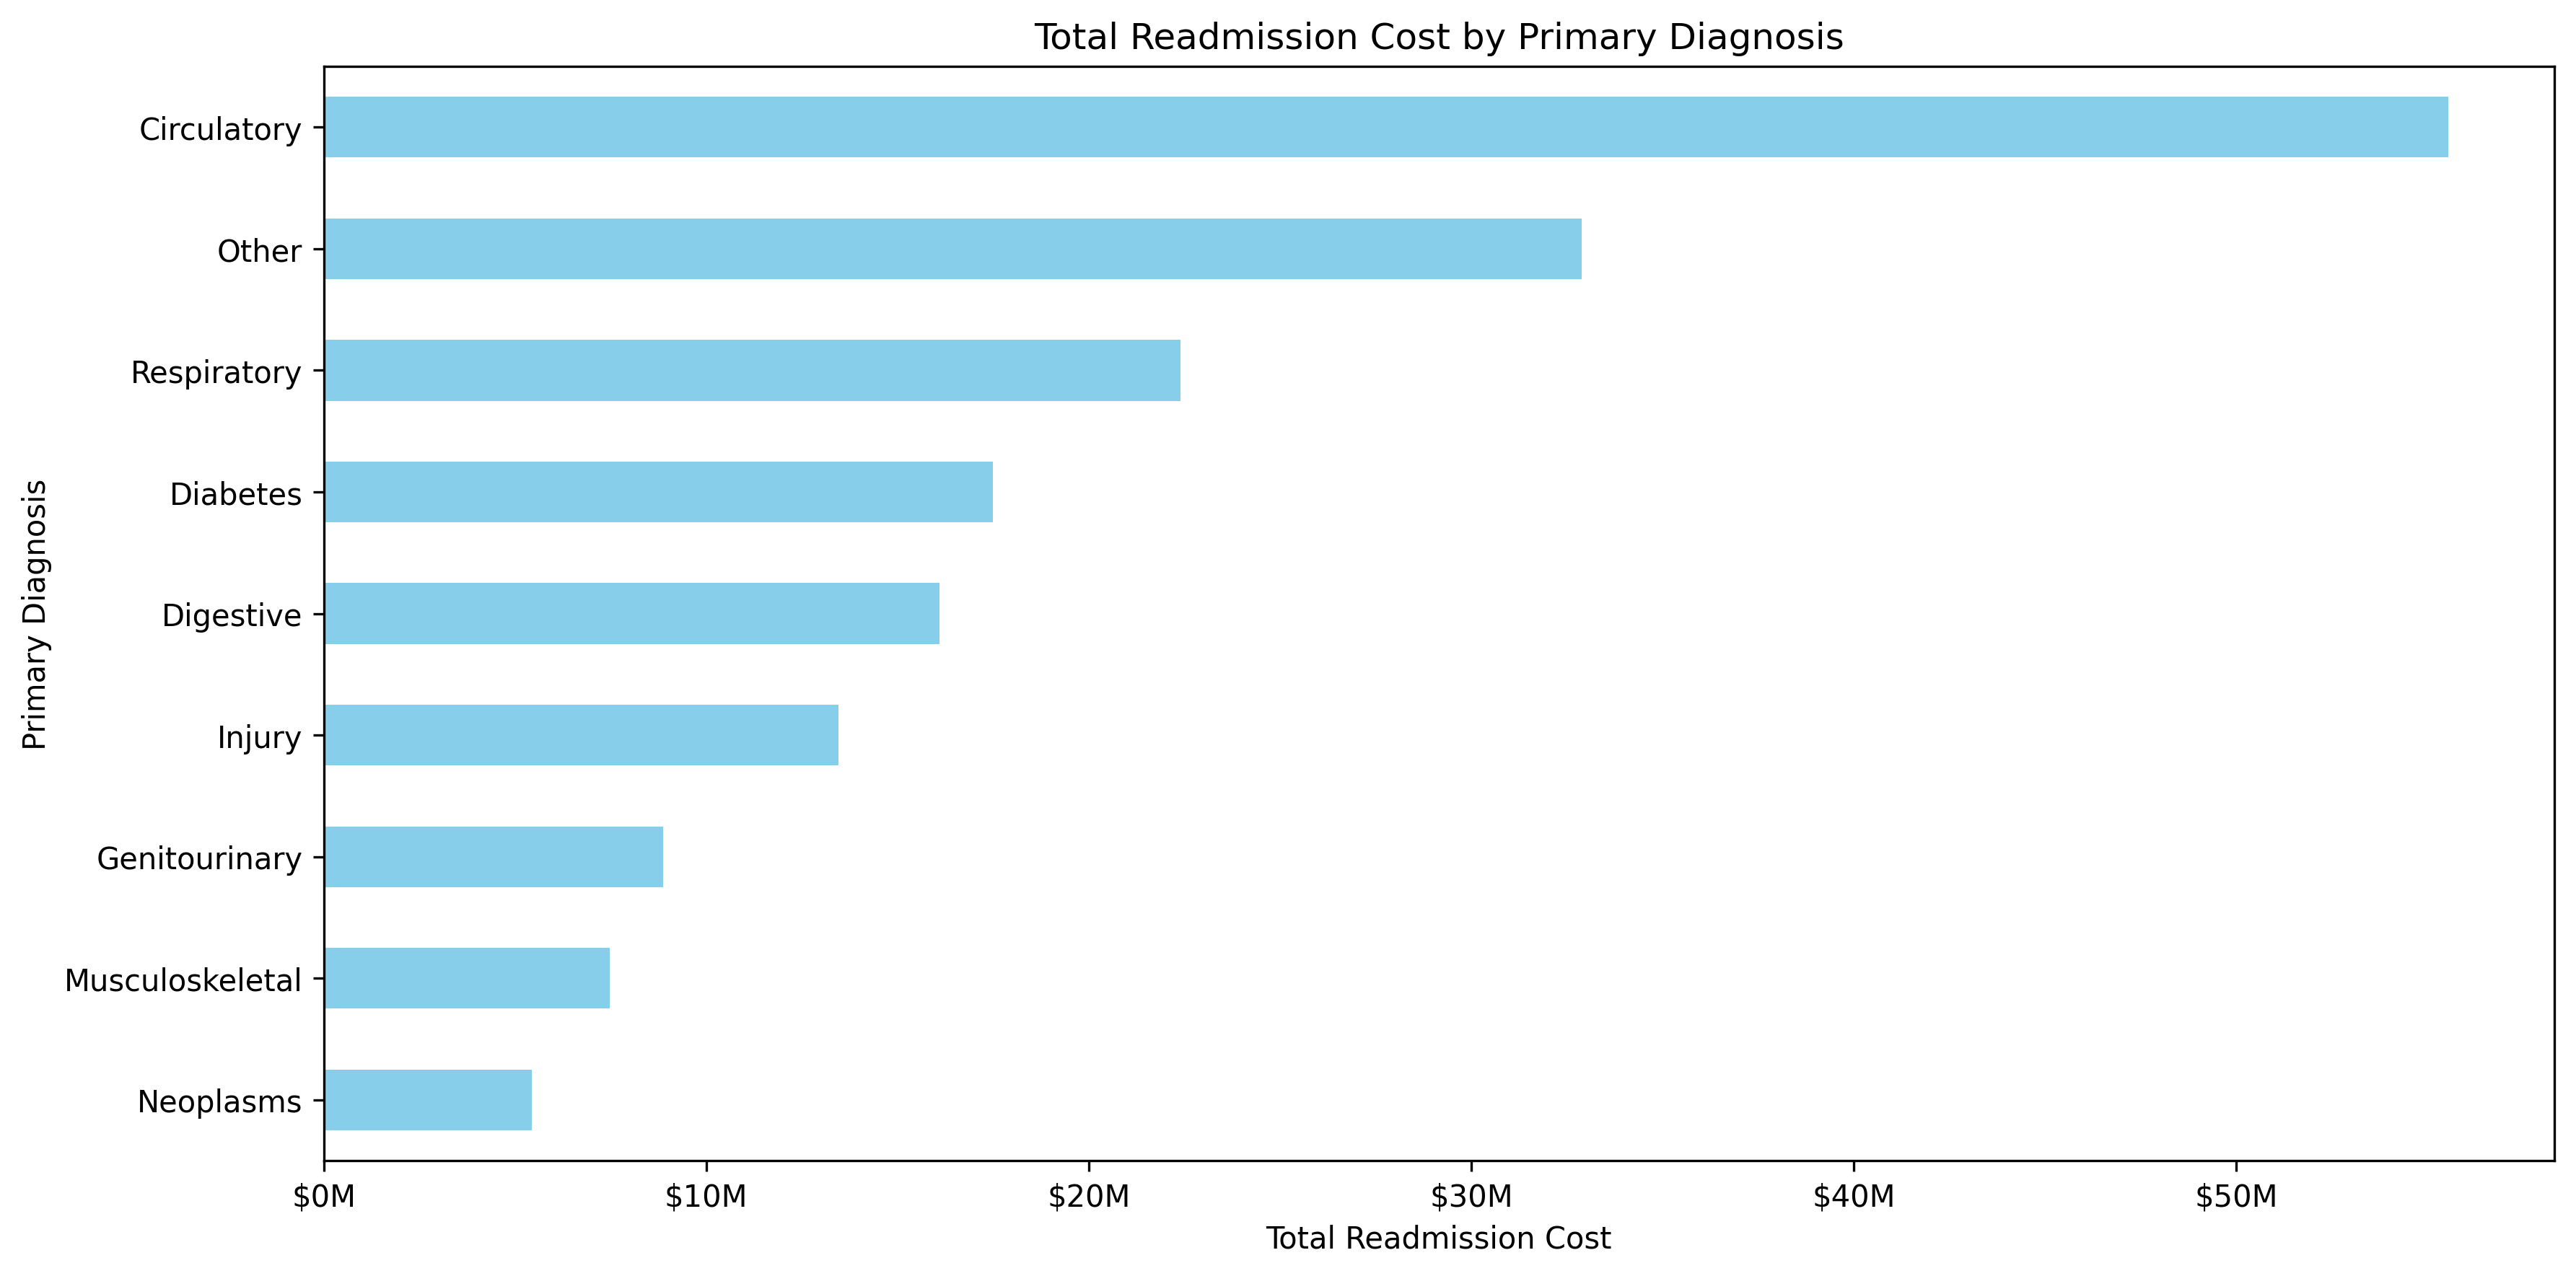

In [2]:
# Assuming the readmission cost of 16,300 USD; here's what readmission costs look like in our dataset
# Total Cost of Readmissions by Primary Diagnosis in millions of USD
from matplotlib import pyplot as plt
cost_per_readmission = 16300
readmission_costs = df.groupby('primary_diagnosis_1')['readmitted_binary'].sum() * cost_per_readmission
readmission_costs = readmission_costs / 1_000_000  # Convert to millions
plt.figure(figsize=(12, 6), dpi = 300)
readmission_costs.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Total Readmission Cost')
plt.ylabel('Primary Diagnosis')
# Add dollar signs and M to the x-axis labels
plt.gca().xaxis.set_major_formatter('${x:,.0f}M')
plt.title('Total Readmission Cost by Primary Diagnosis')
plt.tight_layout()
plt.show()

In [3]:
import matplotlib.pyplot as plt

# Compute metrics
readmitted = df['readmitted_binary'] == 1
readmitted_count = readmitted.sum()
readmitted_cost = readmitted_count * cost_per_readmission
readmitted_cost

179674900

##### Plotting F2 Score

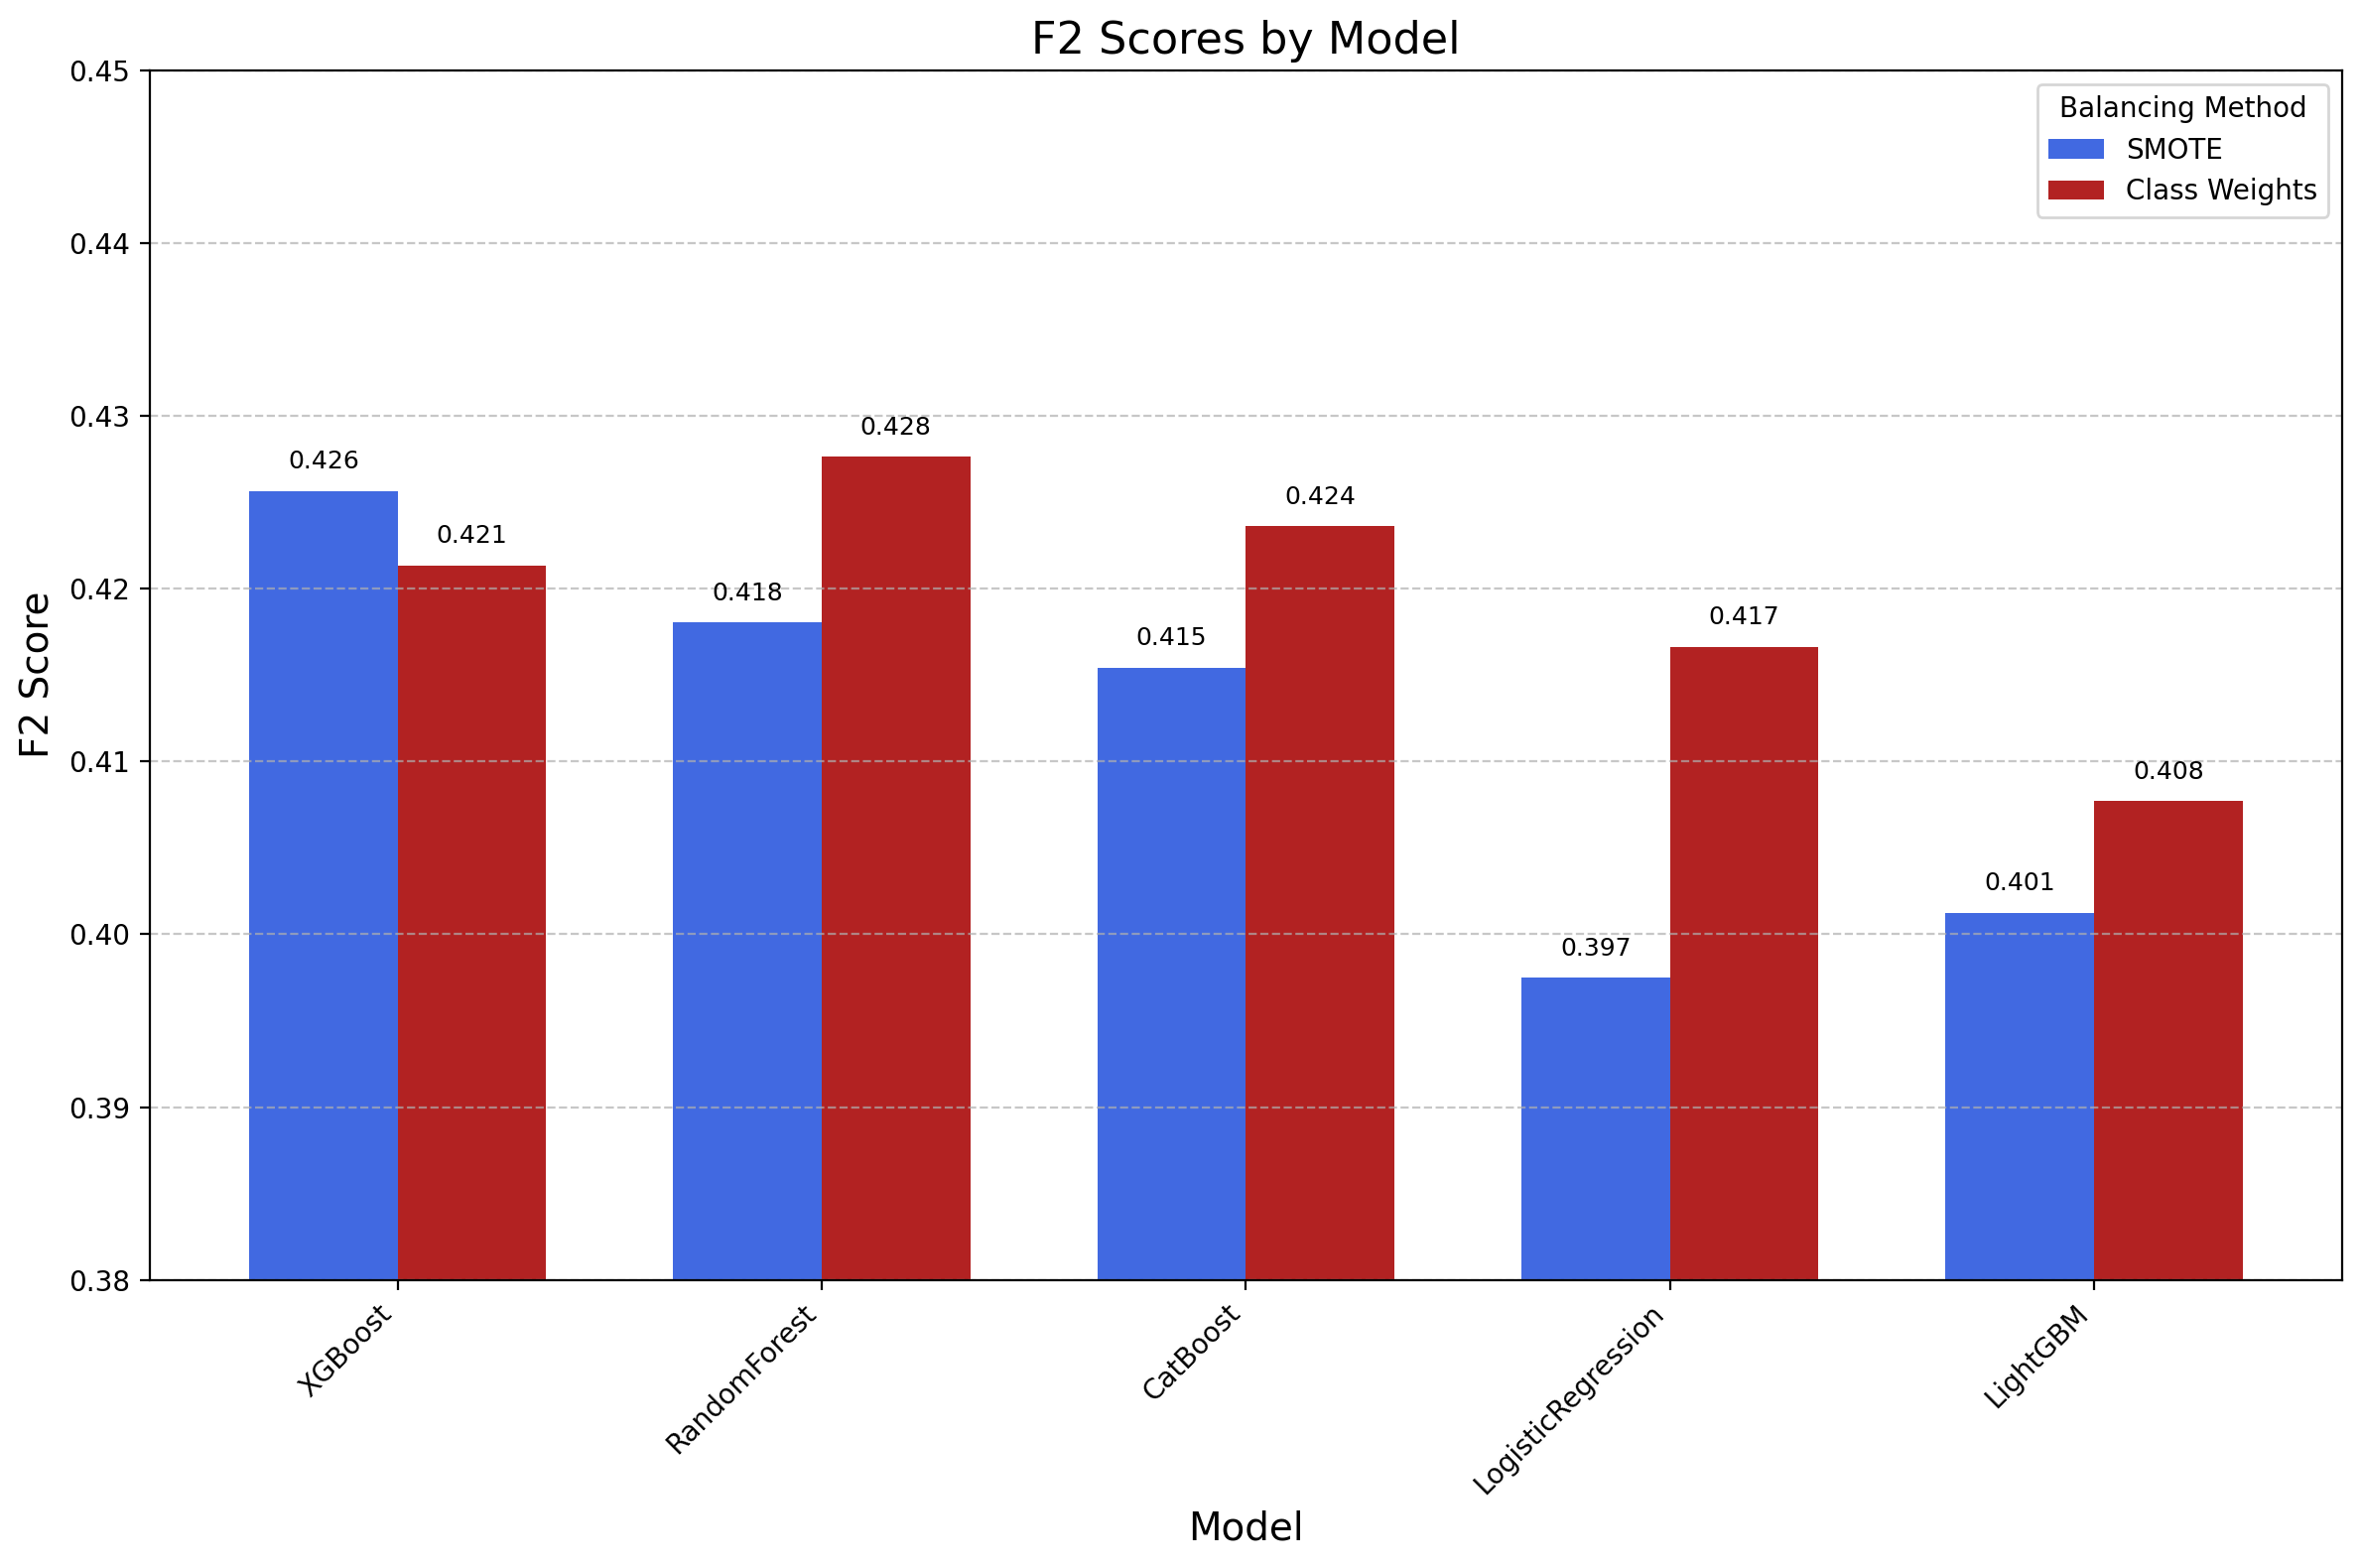

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have metrics_df with F2 scores
f2_scores = metrics_df.loc['F2']

# Create lists to store the separated data
model_types = []
balancing_methods = []
scores = []

# Parse the model names to separate base model and balancing method
for model_name, score in f2_scores.items():
    base_model = model_name.split(' (')[0]
    balance_method = model_name.split('(')[1].replace(')', '')
    
    model_types.append(base_model)
    balancing_methods.append(balance_method)
    scores.append(score)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'Model': model_types,
    'Method': balancing_methods,
    'F2 Score': scores
})

# Set up the plot
plt.figure(figsize=(12, 8), dpi = 200)

# Define colors and markers for different balancing methods
colors = {'SMOTE': 'royalblue', 'Class Weights': 'firebrick'}
markers = {'SMOTE': 'o', 'Class Weights': 's'}

# Determine model order by average F2 score
model_order = plot_df.groupby('Model')['F2 Score'].mean().sort_values(ascending=False).index

# Create barplot with grouped bars
bar_width = 0.35
index = np.arange(len(model_order))

# Plot each balancing method
for i, method in enumerate(['SMOTE', 'Class Weights']):
    method_data = plot_df[plot_df['Method'] == method]
    # Reorder data according to model_order
    ordered_data = pd.DataFrame(index=model_order, columns=['F2 Score'])
    for model in method_data['Model'].unique():
        if model in ordered_data.index:
            ordered_data.loc[model, 'F2 Score'] = method_data[method_data['Model'] == model]['F2 Score'].values[0]
    
    plt.bar(index + (i * bar_width), ordered_data['F2 Score'].values, 
            bar_width, color=colors[method], label=method)

# Customize plot appearance
plt.xlabel('Model', fontsize=14)
plt.ylabel('F2 Score', fontsize=14)
plt.title('F2 Scores by Model', fontsize=16)
plt.xticks(index + bar_width/2, model_order, rotation=45, ha='right')
plt.legend(title='Balancing Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, method in enumerate(['SMOTE', 'Class Weights']):
    method_data = plot_df[plot_df['Method'] == method]
    for j, model in enumerate(model_order):
        model_data = method_data[method_data['Model'] == model]
        if not model_data.empty:
            plt.text(j + (i * bar_width), model_data['F2 Score'].values[0] + 0.001, 
                     f"{model_data['F2 Score'].values[0]:.3f}", 
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.ylim(0.38, 0.45) 
# Display the plot
plt.show()

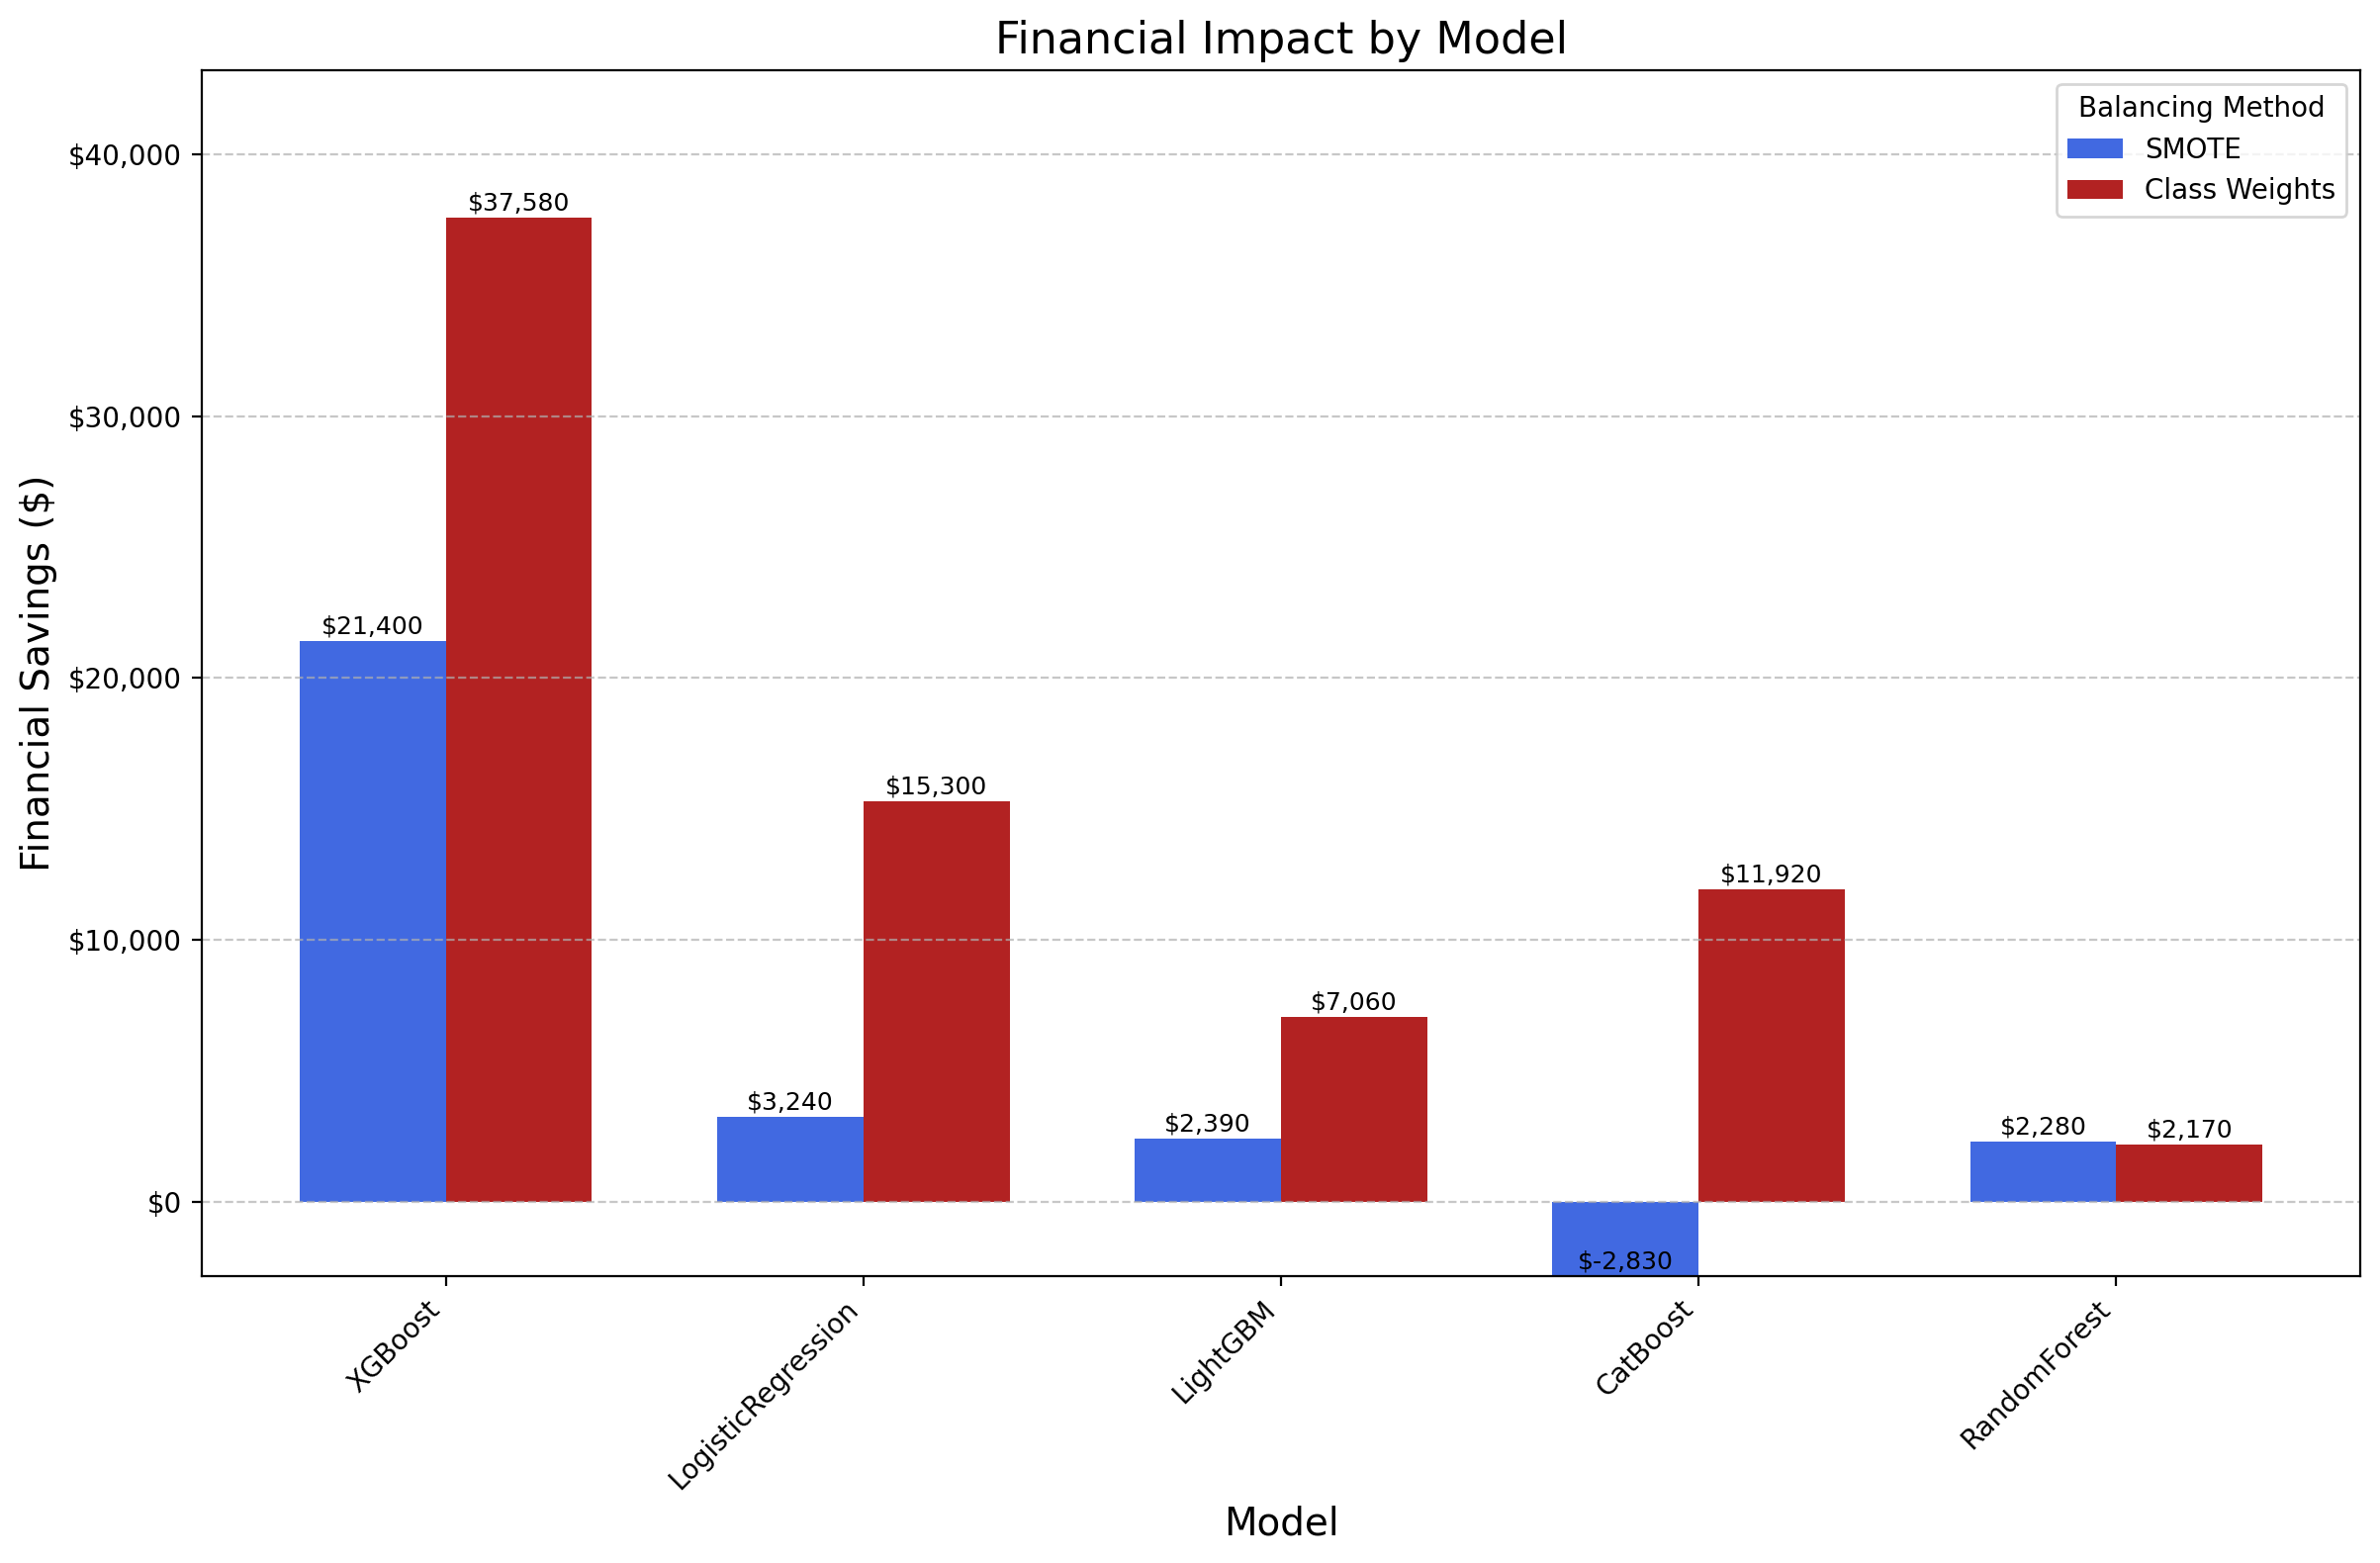

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use financial savings instead of F2 scores
financial_savings = financial_df.loc['Savings ($)']

# Create lists to store the separated data
model_types = []
balancing_methods = []
savings = []

# Parse the model names to separate base model and balancing method
for model_name, saving in financial_savings.items():
    base_model = model_name.split(' (')[0]
    balance_method = model_name.split('(')[1].replace(')', '')
    
    model_types.append(base_model)
    balancing_methods.append(balance_method)
    savings.append(saving)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'Model': model_types,
    'Method': balancing_methods,
    'Savings': savings
})

# Set up the plot
plt.figure(figsize=(12, 8), dpi=200)

# Define colors and markers for different balancing methods
colors = {'SMOTE': 'royalblue', 'Class Weights': 'firebrick'}

# Determine model order by average savings
model_order = plot_df.groupby('Model')['Savings'].mean().sort_values(ascending=False).index

# Create barplot with grouped bars
bar_width = 0.35
index = np.arange(len(model_order))

# Plot each balancing method
for i, method in enumerate(['SMOTE', 'Class Weights']):
    method_data = plot_df[plot_df['Method'] == method]
    
    # Reorder data according to model_order
    ordered_data = pd.DataFrame(index=model_order, columns=['Savings'])
    for model in method_data['Model'].unique():
        if model in ordered_data.index:
            ordered_data.loc[model, 'Savings'] = method_data[method_data['Model'] == model]['Savings'].values[0]
    
    plt.bar(index + (i * bar_width), ordered_data['Savings'].values, 
            bar_width, color=colors[method], label=method)

# Customize plot appearance
plt.xlabel('Model', fontsize=14)
plt.ylabel('Financial Savings ($)', fontsize=14)
plt.title('Financial Impact by Model', fontsize=16)
plt.xticks(index + bar_width/2, model_order, rotation=45, ha='right')
plt.legend(title='Balancing Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, method in enumerate(['SMOTE', 'Class Weights']):
    method_data = plot_df[plot_df['Method'] == method]
    for j, model in enumerate(model_order):
        model_data = method_data[method_data['Model'] == model]
        if not model_data.empty:
            plt.text(j + (i * bar_width), model_data['Savings'].values[0] + 100,
                     f"${model_data['Savings'].values[0]:,.0f}",
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Format y-axis as currency
ax = plt.gca()
ax.yaxis.set_major_formatter('${x:,.0f}')

# Adjust y-limit based on the range of savings
max_saving = plot_df['Savings'].max()
min_saving = plot_df['Savings'].min()
plt.ylim(min_saving, max_saving * 1.15)  # Add 15% padding at the top

# Display the plot
plt.show()

### 30% Intervention Efficacy

In [6]:
intervention_parameter = 0.30
def find_financial_optimal_threshold(y_true, y_pred_proba, 
                                    cost_per_readmission=16300,
                                    cost_per_intervention=2500,
                                    intervention_effectiveness=intervention_parameter):
    """Find threshold that maximizes financial benefit"""
    
    best_threshold = 0
    max_savings = float('-inf')
    
    # Test thresholds
    for threshold in np.linspace(0.01, 0.99, 99):
        results = calculate_financial_impact(
            y_true, y_pred_proba, threshold,
            cost_per_readmission, cost_per_intervention, intervention_effectiveness
        )
        
        if results['Savings'] > max_savings:
            max_savings = results['Savings']
            best_threshold = threshold
            best_results = results
    
    return best_threshold, best_results

def calculate_financial_impact_for_models(probabilities, y_test):
    """Calculate financial impact metrics for all models"""
    financial_metrics = {}
    
    for model_name, y_proba in probabilities.items():
        # Find financially optimal threshold
        financial_threshold, financial_results = find_financial_optimal_threshold(
            y_test, y_proba,
            cost_per_readmission=16300,
            cost_per_intervention=2500,
            intervention_effectiveness=intervention_parameter
        )
        
        # Store financial metrics
        financial_metrics[model_name] = {
            'Financial Threshold': financial_threshold,
            'Savings ($)': financial_results['Savings'],
            'ROI (%)': financial_results['ROI (%)'],
            'Interventions': financial_results['Interventions'],
            'Prevented Readmissions': financial_results['Prevented Readmissions'],
            'TP': financial_results['TP'],
            'FP': financial_results['FP'],
            'TN': financial_results['TN'],
            'FN': financial_results['FN']
        }
    
    # Convert to DataFrame
    financial_df = pd.DataFrame(financial_metrics)
    
    return financial_df


# Now apply financial impact analysis
print("\n--- Financial Impact Analysis ---")
financial_df_30 = calculate_financial_impact_for_models(probabilities, y_test)
print(financial_df_30)

financial_ranking_30 = financial_df_30.loc['Savings ($)'].sort_values(ascending=False)

print("\nBy Financial Savings:")
for i, (model, savings) in enumerate(financial_ranking_30.items(), 1):
    print(f"{i}. {model}: ${savings:,.2f}")


--- Financial Impact Analysis ---
                        CatBoost (SMOTE)  CatBoost (Class Weights)  \
Financial Threshold             0.880000                     0.410   
Savings ($)                 -2830.000000                 11920.000   
ROI (%)                       -16.171429                     9.536   
Interventions                   7.000000                    50.000   
Prevented Readmissions          0.900000                     8.400   
TP                              3.000000                    28.000   
FP                              4.000000                    22.000   
TN                          12694.000000                 12676.000   
FN                           1650.000000                  1625.000   

                        LightGBM (SMOTE)  LightGBM (Class Weights)  \
Financial Threshold                 0.52                      0.52   
Savings ($)                      2390.00                   7060.00   
ROI (%)                            95.60              

### 40% Intervention Efficacy

In [7]:
intervention_parameter = 0.40
def find_financial_optimal_threshold(y_true, y_pred_proba, 
                                    cost_per_readmission=16300,
                                    cost_per_intervention=2500,
                                    intervention_effectiveness=intervention_parameter):
    """Find threshold that maximizes financial benefit"""
    
    best_threshold = 0
    max_savings = float('-inf')
    
    # Test thresholds
    for threshold in np.linspace(0.01, 0.99, 99):
        results = calculate_financial_impact(
            y_true, y_pred_proba, threshold,
            cost_per_readmission, cost_per_intervention, intervention_effectiveness
        )
        
        if results['Savings'] > max_savings:
            max_savings = results['Savings']
            best_threshold = threshold
            best_results = results
    
    return best_threshold, best_results

def calculate_financial_impact_for_models(probabilities, y_test):
    """Calculate financial impact metrics for all models"""
    financial_metrics = {}
    
    for model_name, y_proba in probabilities.items():
        # Find financially optimal threshold
        financial_threshold, financial_results = find_financial_optimal_threshold(
            y_test, y_proba,
            cost_per_readmission=16300,
            cost_per_intervention=2500,
            intervention_effectiveness=intervention_parameter
        )
        
        # Store financial metrics
        financial_metrics[model_name] = {
            'Financial Threshold': financial_threshold,
            'Savings ($)': financial_results['Savings'],
            'ROI (%)': financial_results['ROI (%)'],
            'Interventions': financial_results['Interventions'],
            'Prevented Readmissions': financial_results['Prevented Readmissions'],
            'TP': financial_results['TP'],
            'FP': financial_results['FP'],
            'TN': financial_results['TN'],
            'FN': financial_results['FN']
        }
    
    # Convert to DataFrame
    financial_df = pd.DataFrame(financial_metrics)
    
    return financial_df


# Now apply financial impact analysis
print("\n--- Financial Impact Analysis ---")
financial_df_40 = calculate_financial_impact_for_models(probabilities, y_test)
print(financial_df_40)

financial_ranking_40 = financial_df_40.loc['Savings ($)'].sort_values(ascending=False)

print("\nBy Financial Savings:")
for i, (model, savings) in enumerate(financial_ranking_40.items(), 1):
    print(f"{i}. {model}: ${savings:,.2f}")


--- Financial Impact Analysis ---
                        CatBoost (SMOTE)  CatBoost (Class Weights)  \
Financial Threshold             0.290000                  0.290000   
Savings ($)                 33900.000000              63120.000000   
ROI (%)                         8.023669                 13.574194   
Interventions                 169.000000                186.000000   
Prevented Readmissions         28.000000                 32.400000   
TP                             70.000000                 81.000000   
FP                             99.000000                105.000000   
TN                          12599.000000              12593.000000   
FN                           1583.000000               1572.000000   

                        LightGBM (SMOTE)  LightGBM (Class Weights)  \
Financial Threshold             0.380000                  0.440000   
Savings ($)                 14660.000000              22700.000000   
ROI (%)                        39.093333              

### 50% Intervention Efficacy

In [8]:
intervention_parameter = 0.50
def find_financial_optimal_threshold(y_true, y_pred_proba, 
                                    cost_per_readmission=16300,
                                    cost_per_intervention=2500,
                                    intervention_effectiveness=intervention_parameter):
    """Find threshold that maximizes financial benefit"""
    
    best_threshold = 0
    max_savings = float('-inf')
    
    # Test thresholds
    for threshold in np.linspace(0.01, 0.99, 99):
        results = calculate_financial_impact(
            y_true, y_pred_proba, threshold,
            cost_per_readmission, cost_per_intervention, intervention_effectiveness
        )
        
        if results['Savings'] > max_savings:
            max_savings = results['Savings']
            best_threshold = threshold
            best_results = results
    
    return best_threshold, best_results

def calculate_financial_impact_for_models(probabilities, y_test):
    """Calculate financial impact metrics for all models"""
    financial_metrics = {}
    
    for model_name, y_proba in probabilities.items():
        # Find financially optimal threshold
        financial_threshold, financial_results = find_financial_optimal_threshold(
            y_test, y_proba,
            cost_per_readmission=16300,
            cost_per_intervention=2500,
            intervention_effectiveness=intervention_parameter
        )
        
        # Store financial metrics
        financial_metrics[model_name] = {
            'Financial Threshold': financial_threshold,
            'Savings ($)': financial_results['Savings'],
            'ROI (%)': financial_results['ROI (%)'],
            'Interventions': financial_results['Interventions'],
            'Prevented Readmissions': financial_results['Prevented Readmissions'],
            'TP': financial_results['TP'],
            'FP': financial_results['FP'],
            'TN': financial_results['TN'],
            'FN': financial_results['FN']
        }
    
    # Convert to DataFrame
    financial_df = pd.DataFrame(financial_metrics)
    
    return financial_df


# Now apply financial impact analysis
print("\n--- Financial Impact Analysis ---")
financial_df_50 = calculate_financial_impact_for_models(probabilities, y_test)
print(financial_df_50)

financial_ranking_50 = financial_df_50.loc['Savings ($)'].sort_values(ascending=False)

print("\nBy Financial Savings:")
for i, (model, savings) in enumerate(financial_ranking_50.items(), 1):
    print(f"{i}. {model}: ${savings:,.2f}")


--- Financial Impact Analysis ---
                        CatBoost (SMOTE)  CatBoost (Class Weights)  \
Financial Threshold             0.270000                  0.290000   
Savings ($)                150450.000000             195150.000000   
ROI (%)                        24.765432                 41.967742   
Interventions                 243.000000                186.000000   
Prevented Readmissions         46.500000                 40.500000   
TP                             93.000000                 81.000000   
FP                            150.000000                105.000000   
TN                          12548.000000              12593.000000   
FN                           1560.000000               1572.000000   

                        LightGBM (SMOTE)  LightGBM (Class Weights)  \
Financial Threshold             0.260000                  0.270000   
Savings ($)                 40800.000000              84350.000000   
ROI (%)                        18.545455              

### Intervention Effectiveness

/var/folders/sk/1lq3mdt55q3579qwycd7hv4c0000gn/T/ipykernel_33766/606498238.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(financial_summary['Model'].unique()))


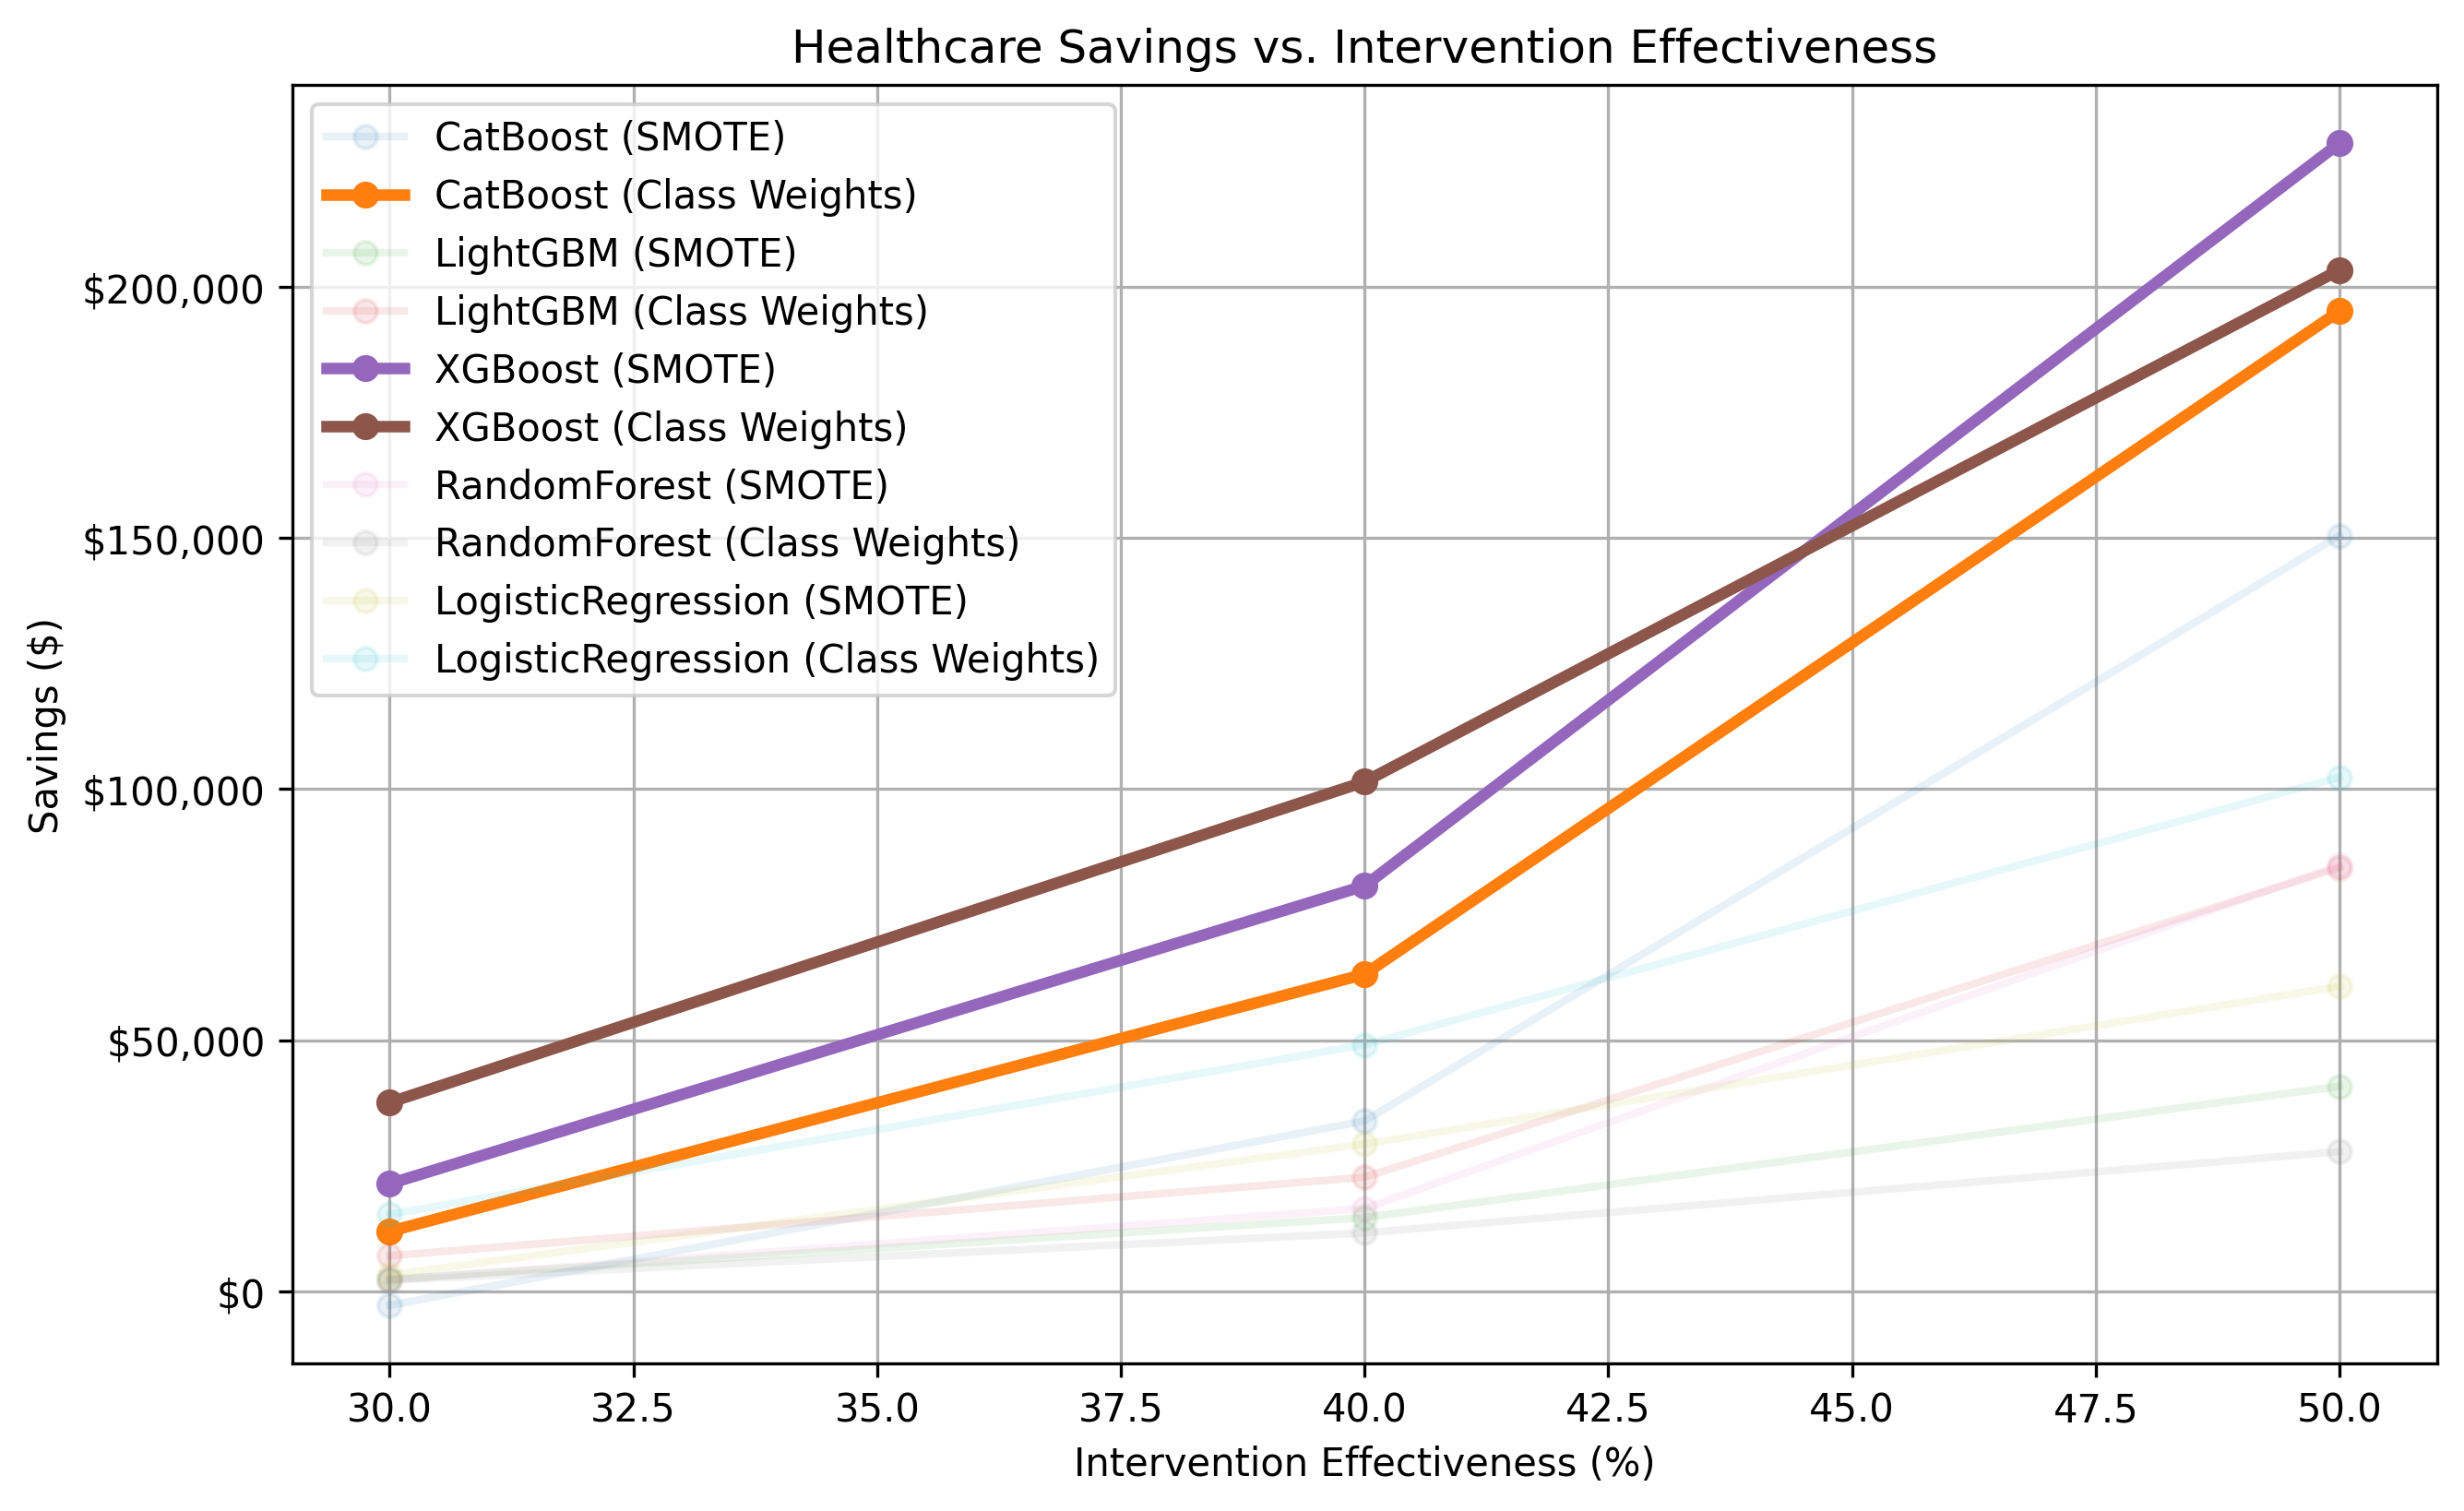

In [9]:
# Assuming financial_df_30, financial_df_40, and financial_df_50 are already computed
intervention_levels = [30, 40, 50]
financial_dfs = {
    30: financial_df_30,
    40: financial_df_40,
    50: financial_df_50
}

# Combine results into a single DataFrame
summary_df = pd.concat(
    {level: df.T for level, df in financial_dfs.items()}, 
    axis=0
).reset_index()

# Rename columns for clarity
summary_df.rename(columns={'level_0': 'Intervention Effectiveness', 'level_1': 'Model'}, inplace=True)

# Select key financial metrics
financial_summary = summary_df[['Intervention Effectiveness', 'Model', 'Savings ($)', 'ROI (%)', 'Financial Threshold', 'Interventions', 'Prevented Readmissions']]


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Define models to highlight
highlight_models = ["XGBoost (Class Weights)", "CatBoost (Class Weights)", "XGBoost (SMOTE)"]

plt.figure(figsize=(10, 6), dpi = 300)

# Use a colormap for consistent colors
colors = plt.cm.get_cmap("tab10", len(financial_summary['Model'].unique()))

# Plot each model separately with color and adjusted opacity
for i, model in enumerate(financial_summary['Model'].unique()):
    model_data = financial_summary[financial_summary['Model'] == model]
    
    # Apply full opacity for key models, lower opacity for others
    alpha_value = 1 if model in highlight_models else 0.1  # Reduce opacity for non-key models
    
    plt.plot(model_data['Intervention Effectiveness'], model_data['Savings ($)'], 
             marker='o', linewidth=3 if model in highlight_models else 2, 
             alpha=alpha_value, color=colors(i), label=model)  # Preserve original colors

plt.xlabel("Intervention Effectiveness (%)")
plt.ylabel("Savings ($)")
plt.title("Healthcare Savings vs. Intervention Effectiveness")

# Format y-axis to display dollar signs
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.legend()
plt.grid(True)
plt.show()

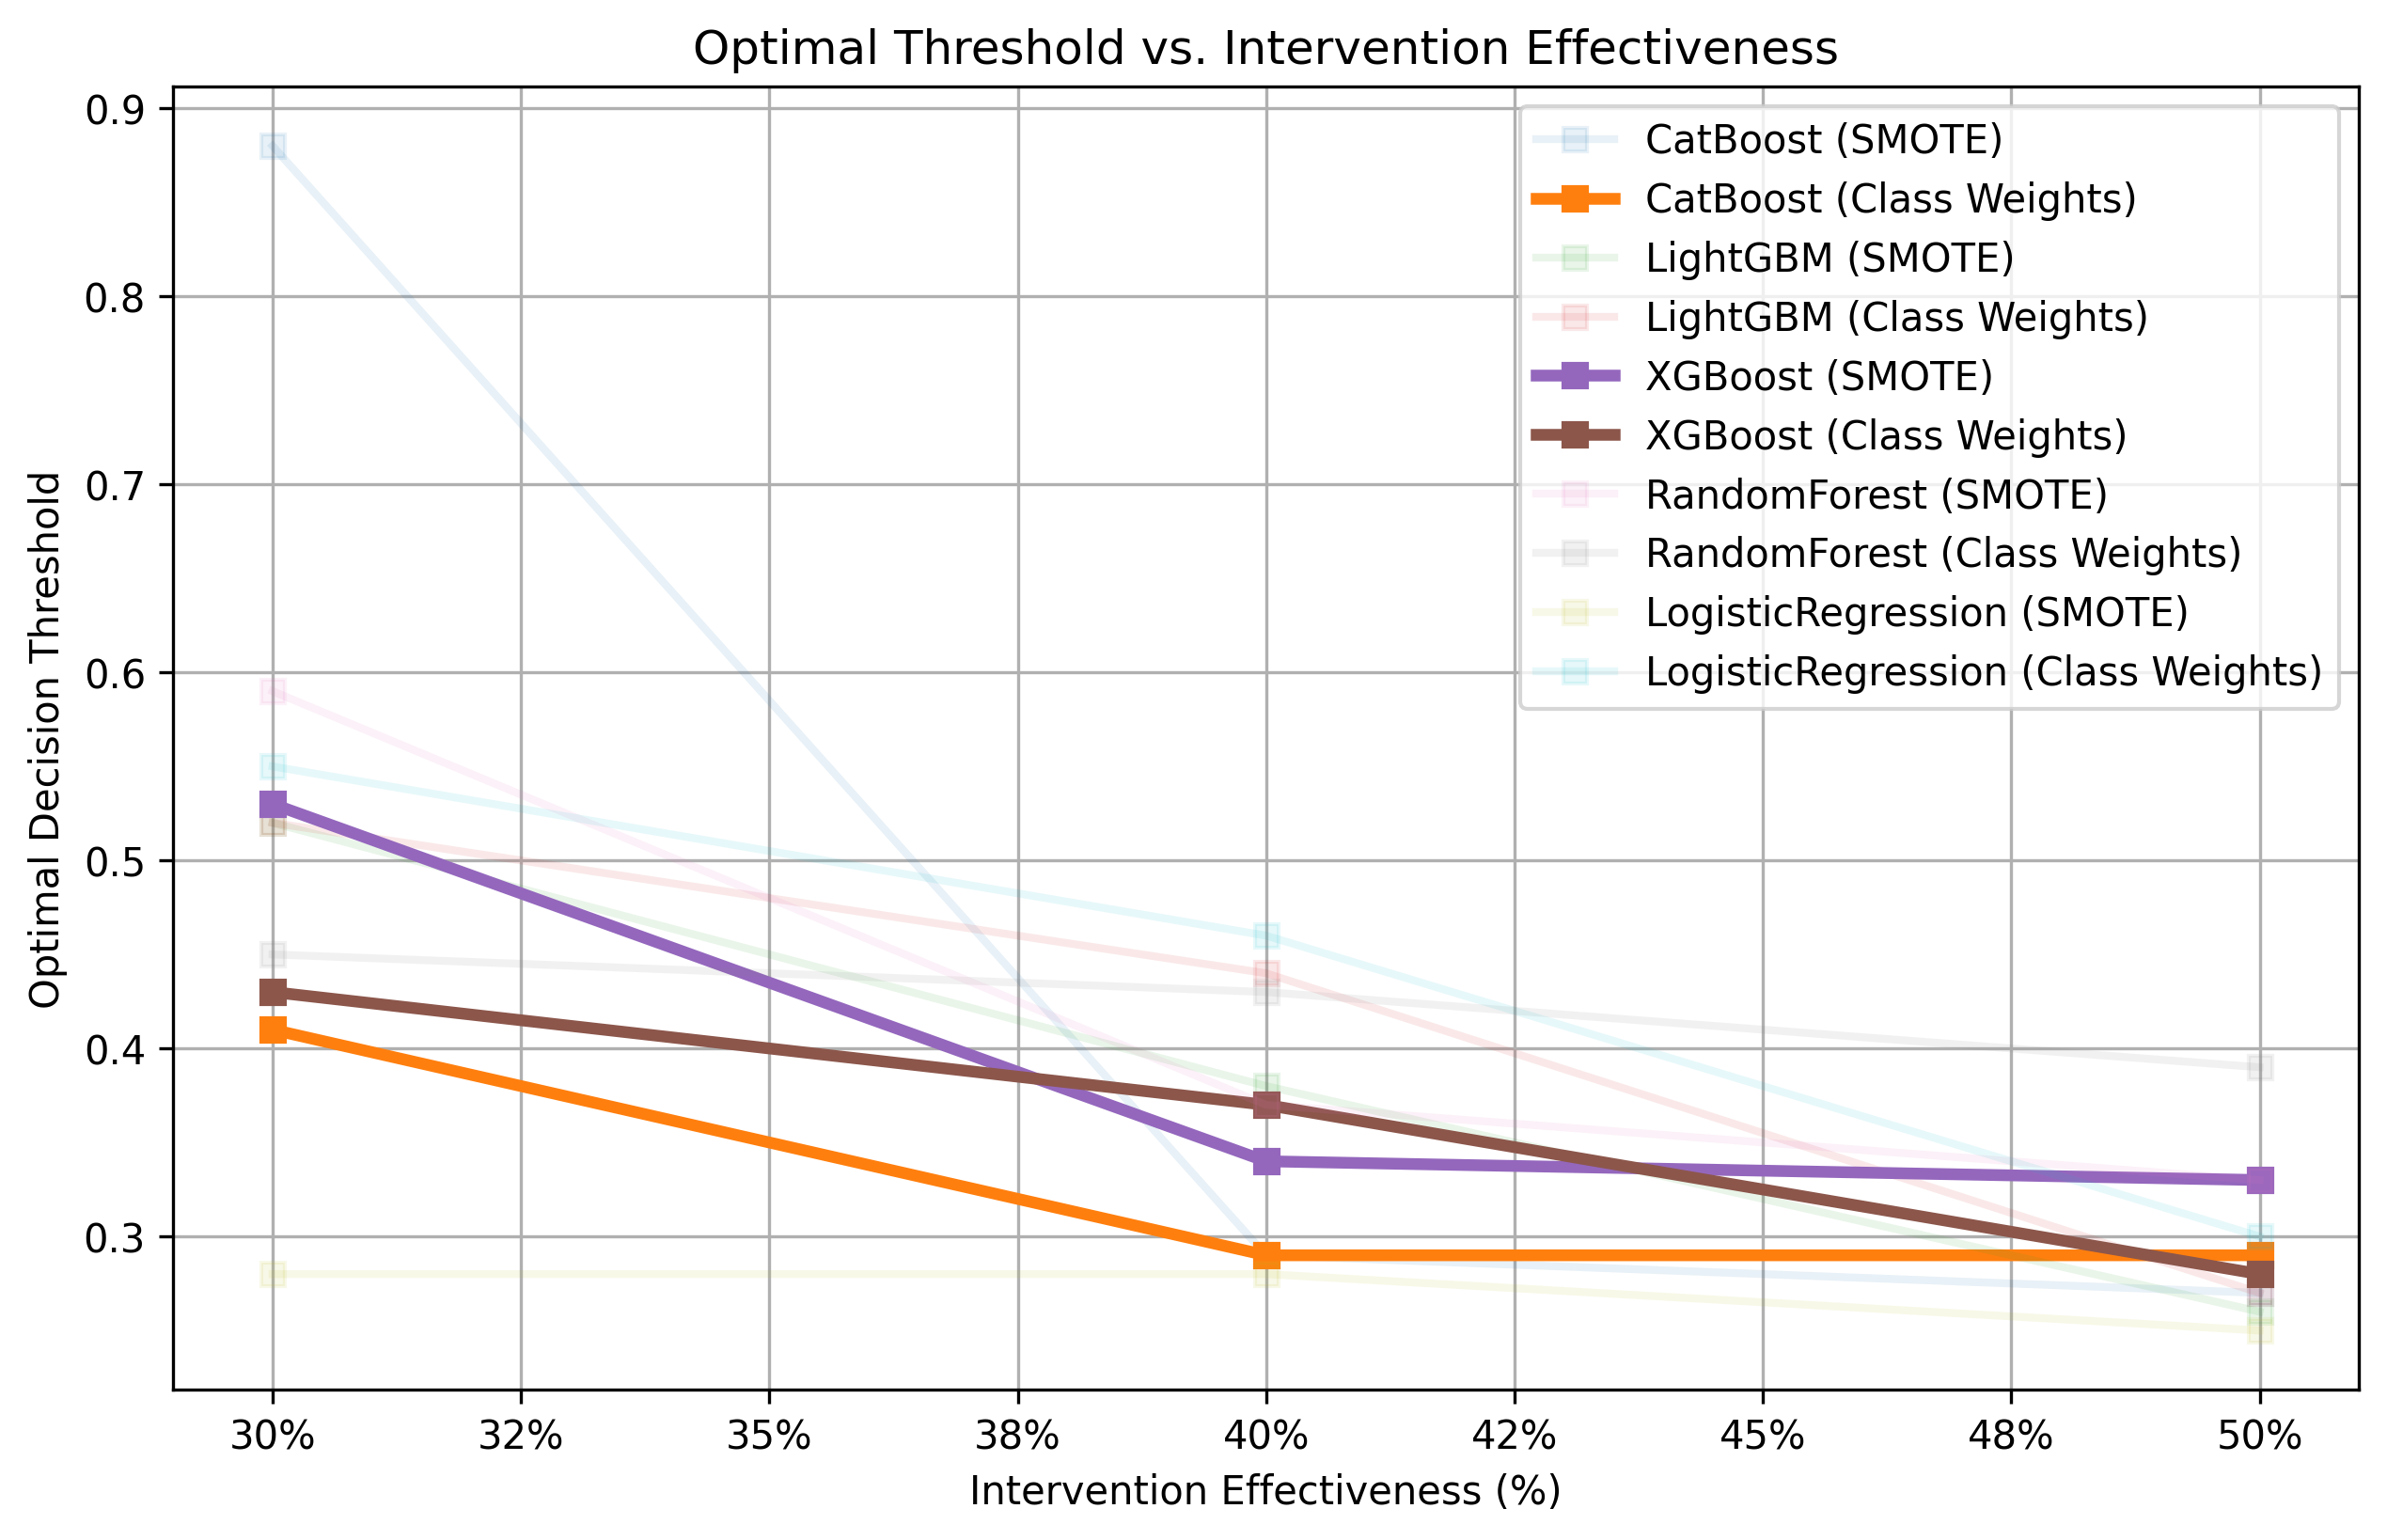

In [10]:
plt.figure(figsize=(10, 6), dpi = 300)
# Plot each model separately with color and adjusted opacity
for i, model in enumerate(financial_summary['Model'].unique()):
    model_data = financial_summary[financial_summary['Model'] == model]
    
    # Apply full opacity for key models, lower opacity for others
    alpha_value = 1 if model in highlight_models else 0.1  # Reduce opacity for non-key models
    
    plt.plot(model_data['Intervention Effectiveness'], model_data['Financial Threshold'], 
             marker='s', linewidth=3 if model in highlight_models else 2, 
             alpha=alpha_value, color=colors(i), label=model)  # Preserve original colors

plt.xlabel("Intervention Effectiveness (%)")
plt.ylabel("Optimal Decision Threshold")
plt.title("Optimal Threshold vs. Intervention Effectiveness")
# Format y-axis to display percentage
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:2.1f}'))
# Format x-axis to display percentage
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}%'))
# Legend in top right corner
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Calibration Analysis

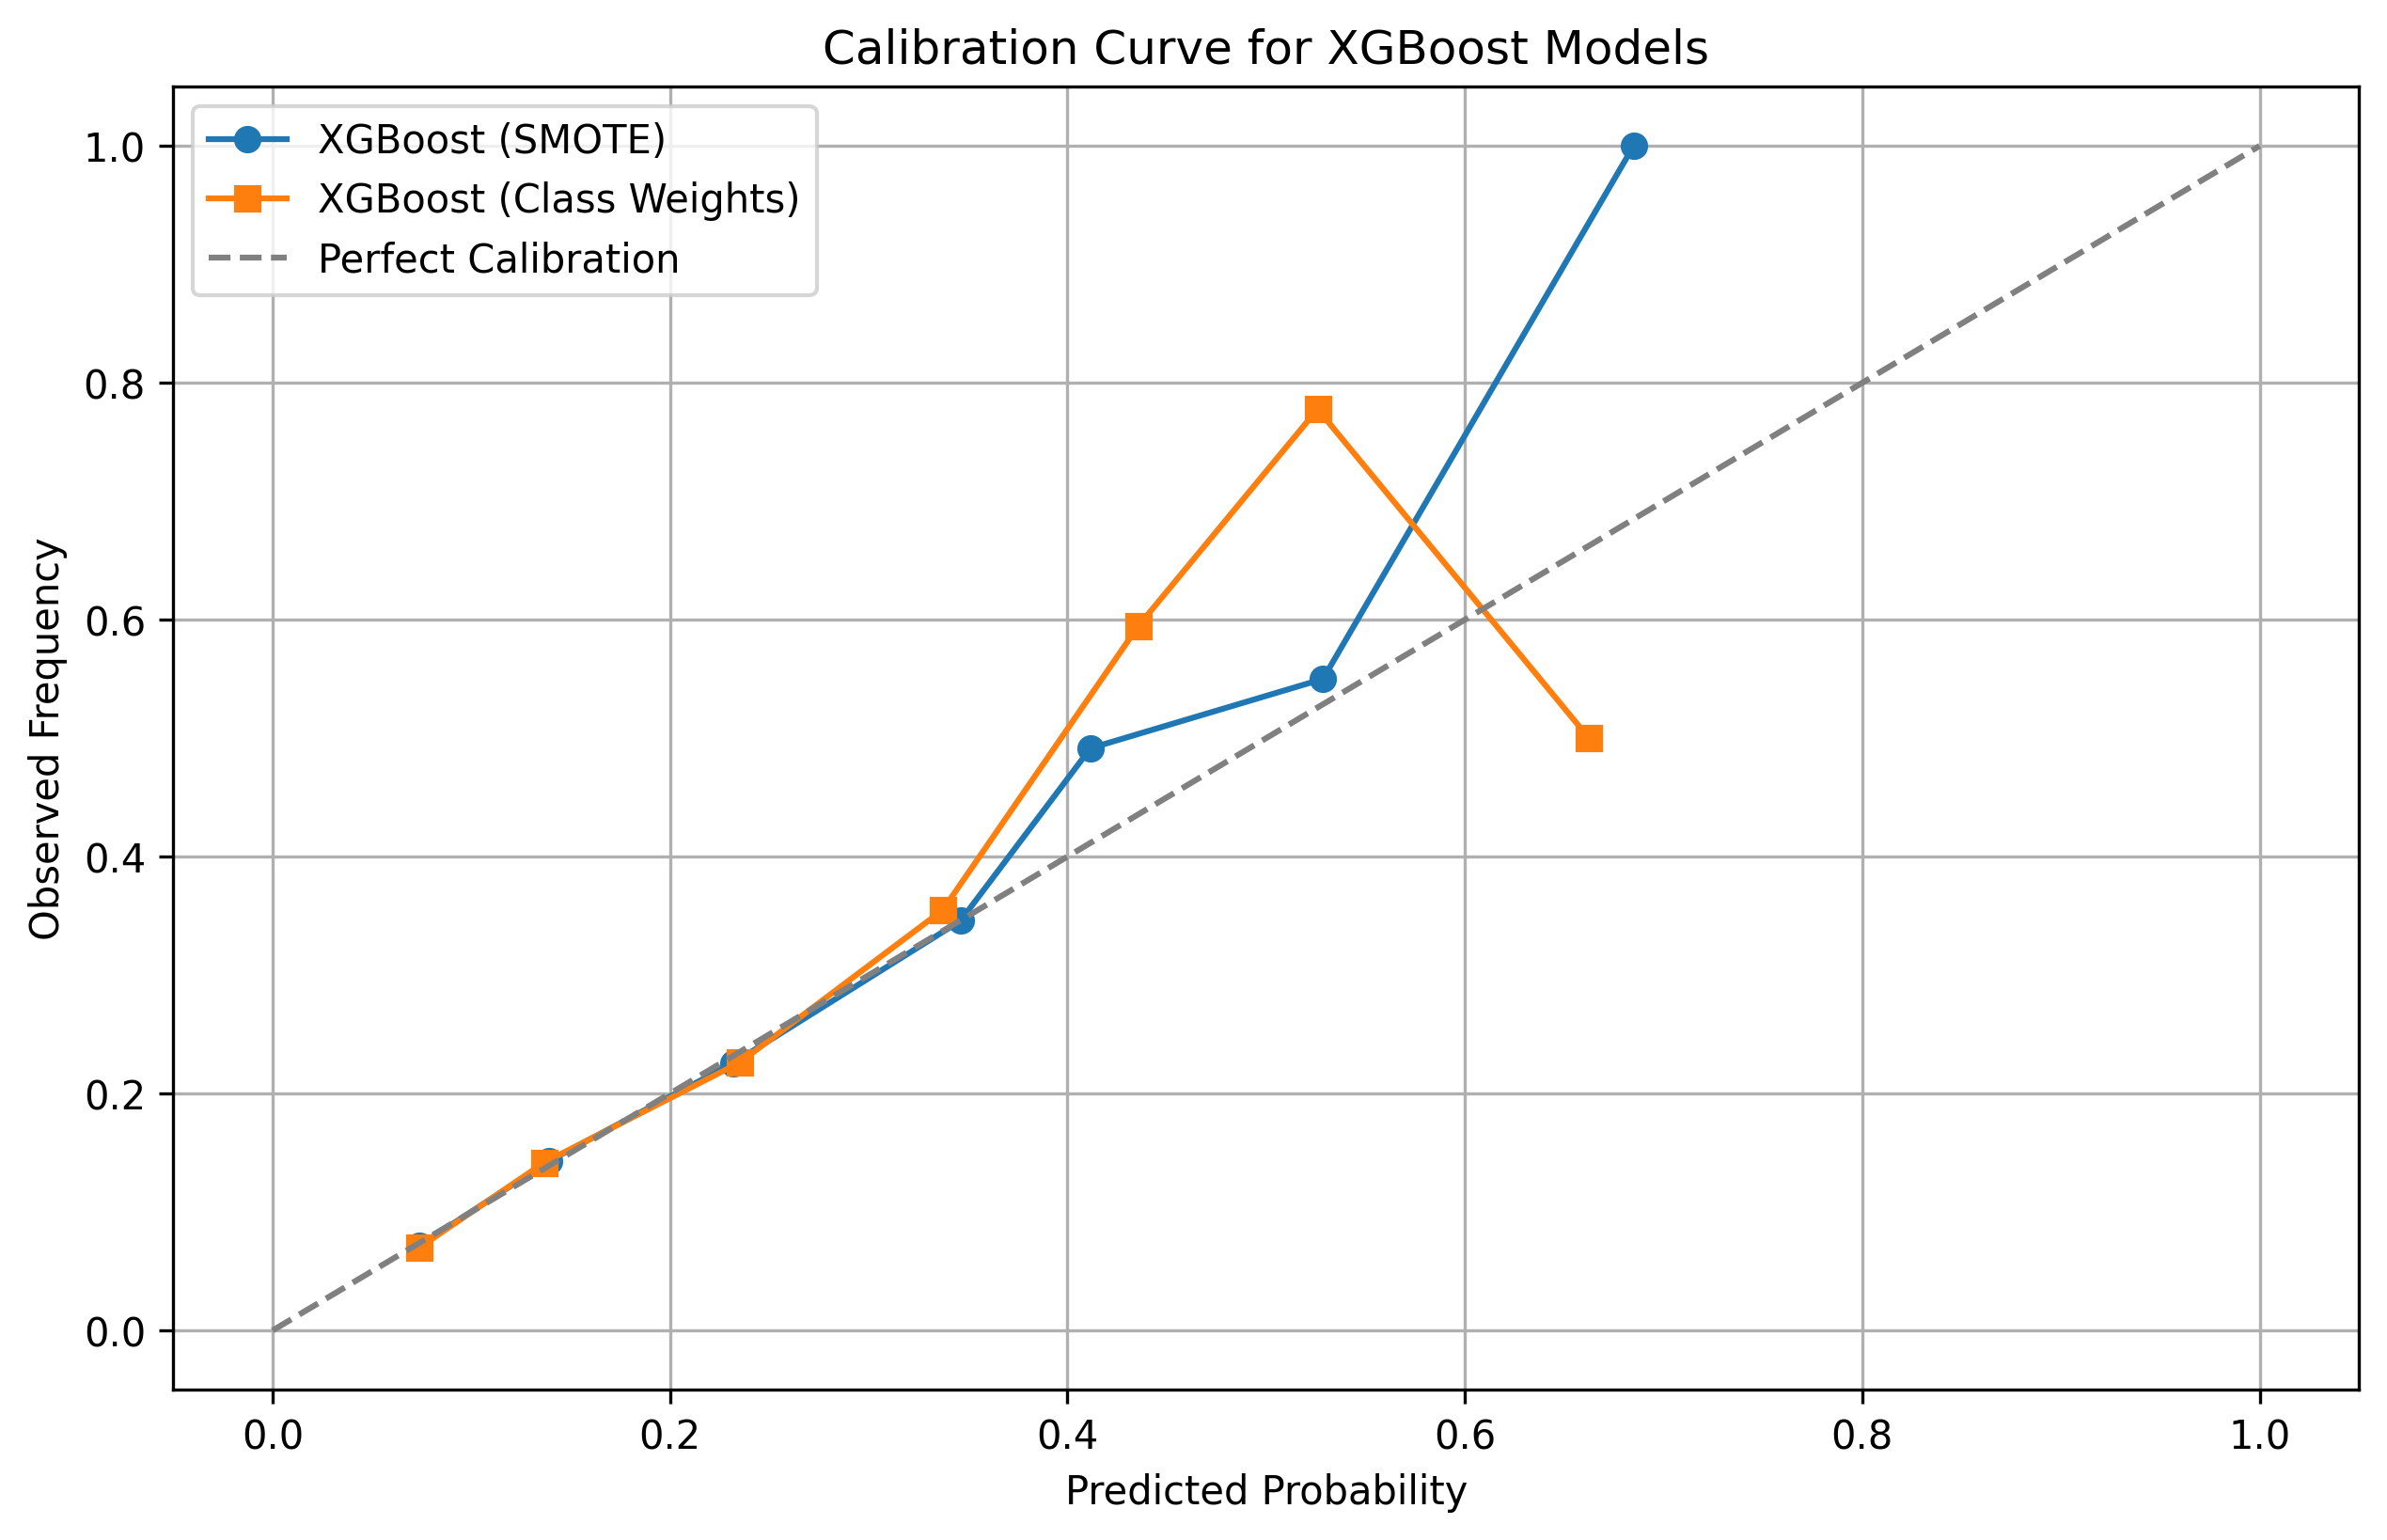

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Extracting probabilities for XGBoost models
probabilities_xgb_smote = probabilities['XGBoost (SMOTE)']
probabilities_xgb_class_weights = probabilities['XGBoost (Class Weights)']

# Assuming y_test is provided
# Compute calibration curves
prob_true_smote, prob_pred_smote = calibration_curve(y_test, probabilities_xgb_smote, n_bins=10, strategy='uniform')
prob_true_class_weights, prob_pred_class_weights = calibration_curve(y_test, probabilities_xgb_class_weights, n_bins=10, strategy='uniform')

# Plot calibration curves
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(prob_pred_smote, prob_true_smote, marker='o', label="XGBoost (SMOTE)")
plt.plot(prob_pred_class_weights, prob_true_class_weights, marker='s', label="XGBoost (Class Weights)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")  # Reference line
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve for XGBoost Models")
plt.legend()
plt.grid()
plt.show()

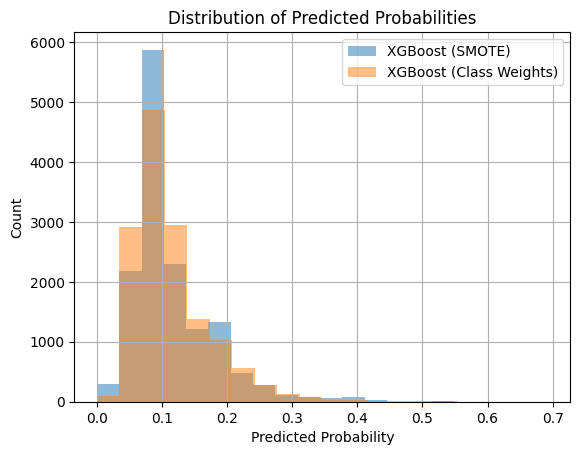

In [12]:
plt.hist(probabilities_xgb_smote, bins=20, alpha=0.5, label="XGBoost (SMOTE)")
plt.hist(probabilities_xgb_class_weights, bins=20, alpha=0.5, label="XGBoost (Class Weights)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Predicted Probabilities")
plt.grid()
plt.show()


 97%|=================== | 13891/14351 [00:21<00:00]       

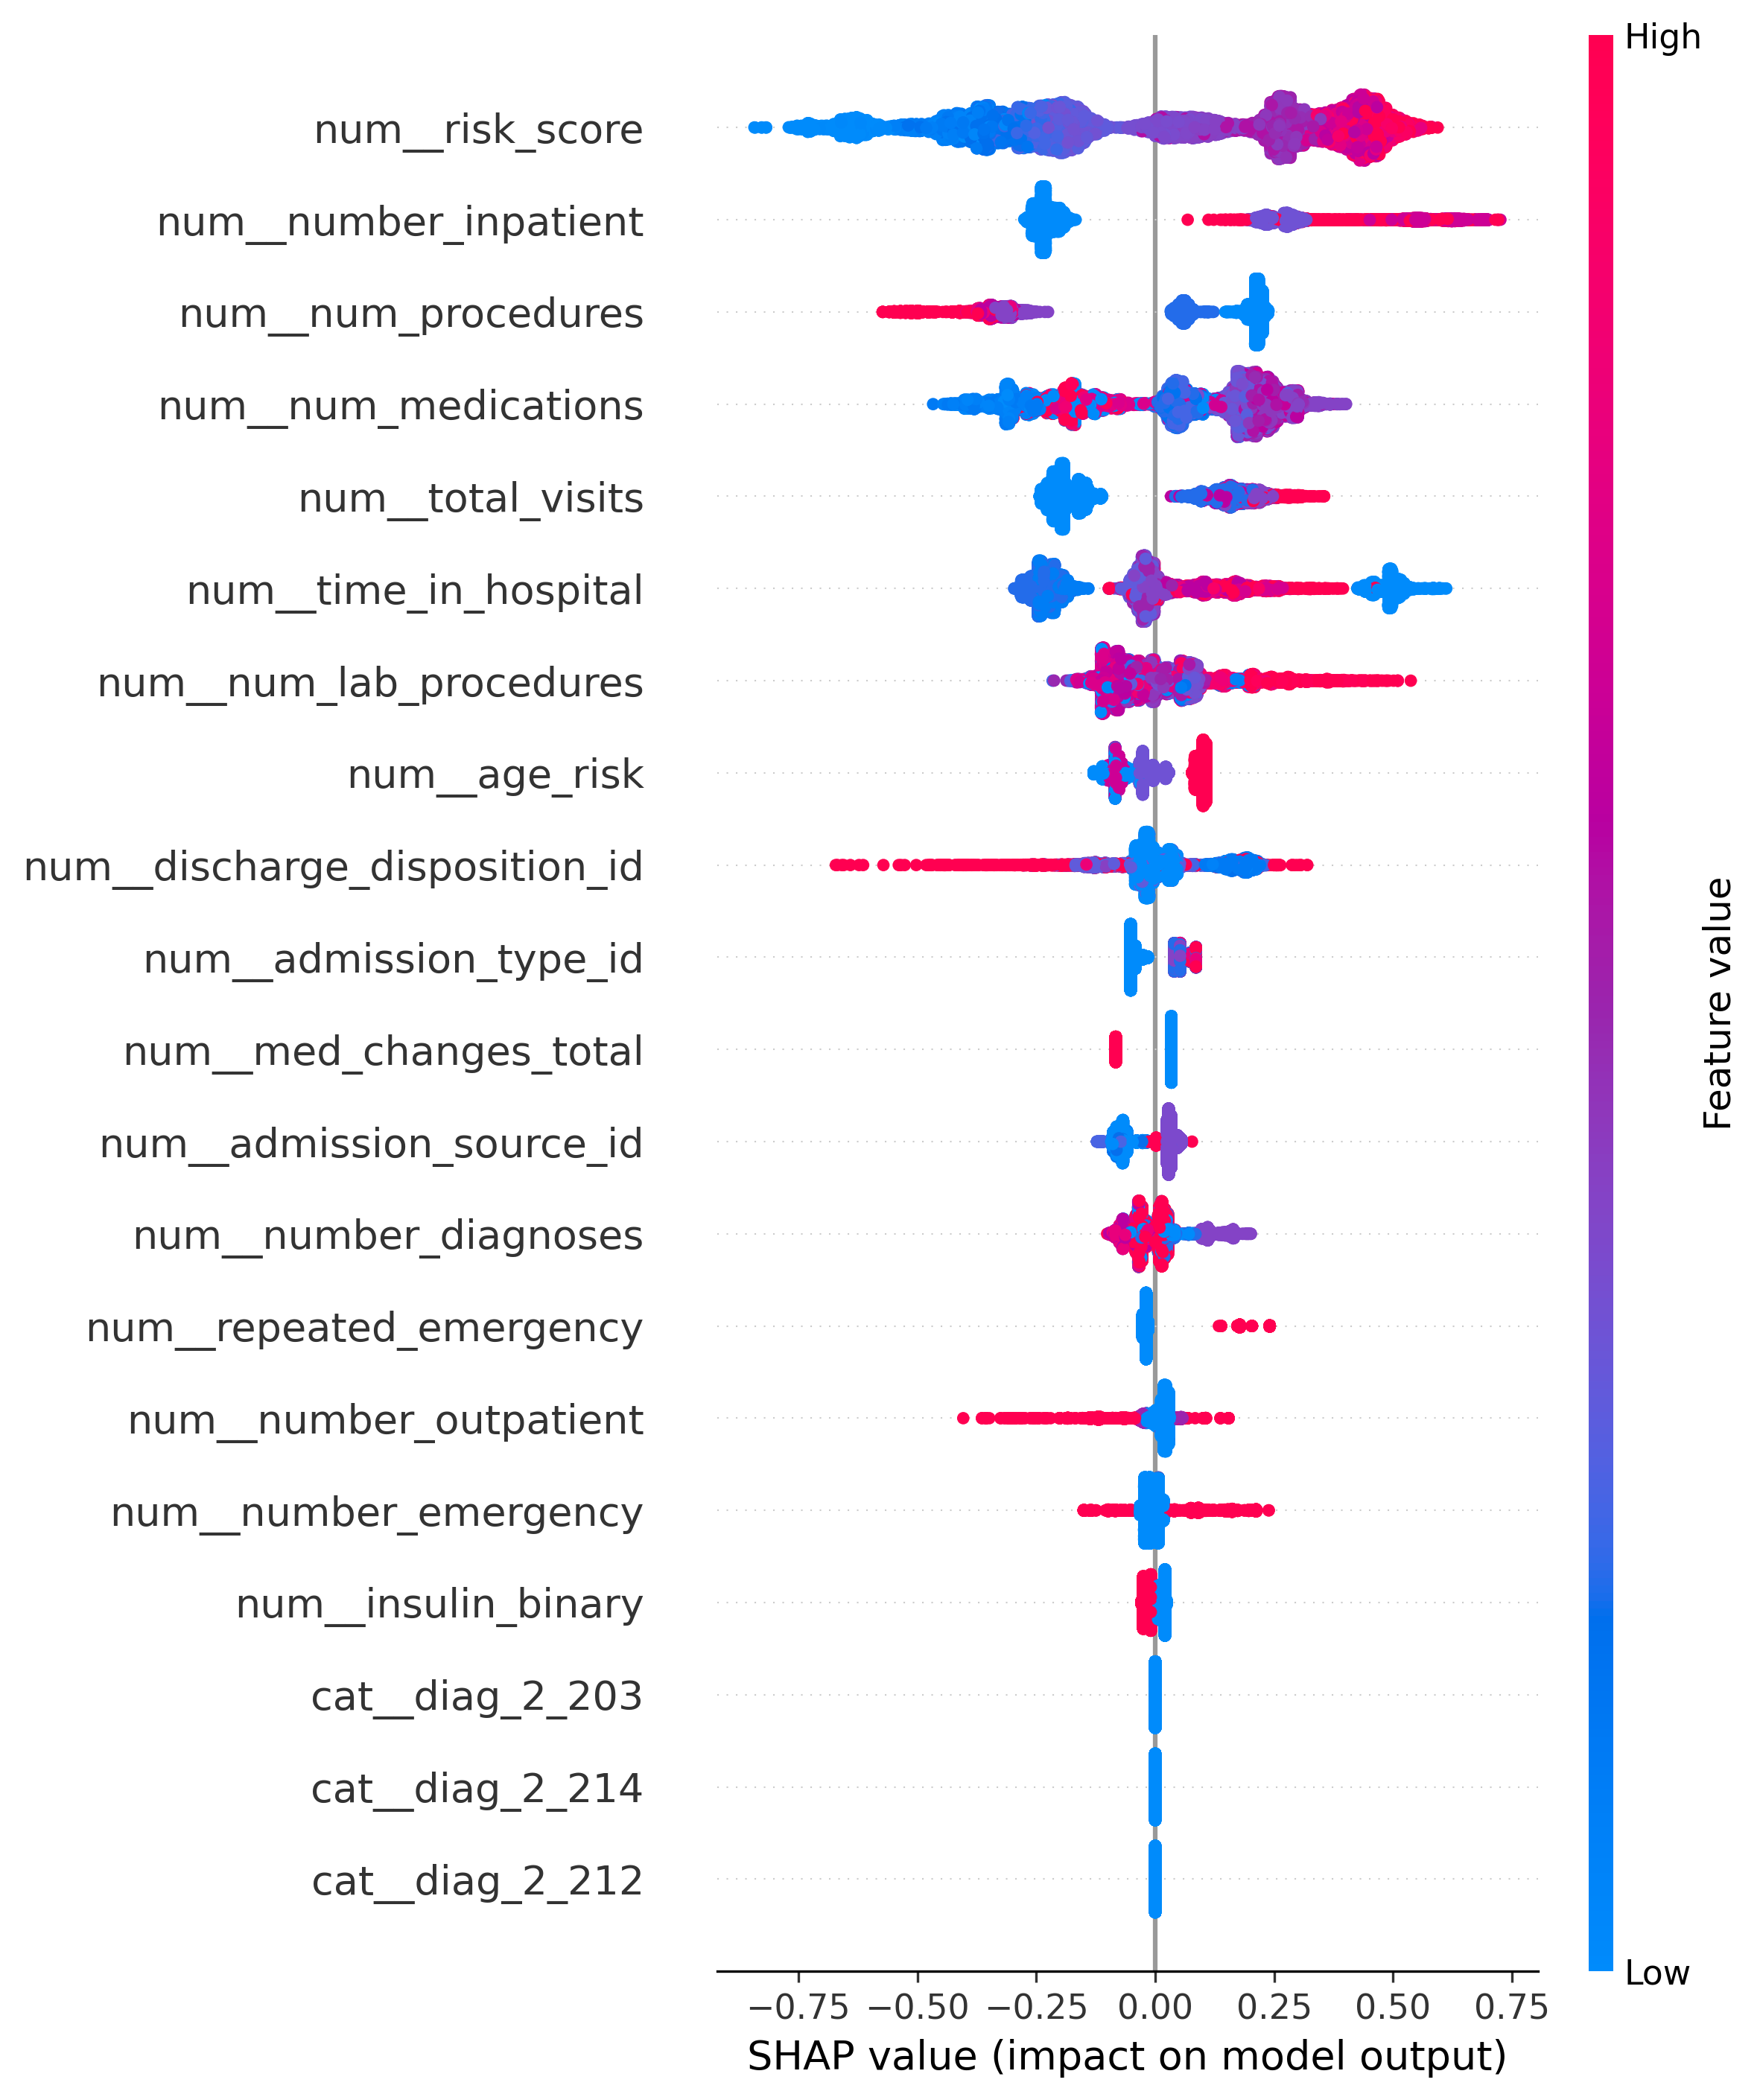

In [34]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Import for DPI setting

# Extract preprocessor and XGBoost model
preprocessor = xgboost_uncalib.named_steps['preprocessor']
xgb_model = xgboost_uncalib.named_steps['xgboost']

# Transform test data
X_test_transformed = preprocessor.transform(X_test)

# 🔹 Convert sparse matrix (if applicable) to dense NumPy array
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# 🔹 Extract feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# 🔹 Convert transformed data back to a DataFrame with feature names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Select background data for SHAP (use a small subset for efficiency)
X_background = X_test_transformed_df.iloc[:100]  # Adjust size if needed

# Initialize TreeExplainer for fast SHAP calculations
explainer = shap.TreeExplainer(xgb_model, data=X_background)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed_df)

# 🔹 Increase DPI to 300
plt.figure(dpi=300)  

# Plot SHAP summary with higher resolution
shap.summary_plot(shap_values, X_test_transformed_df)


 99%|===================| 14231/14351 [00:21<00:00]        

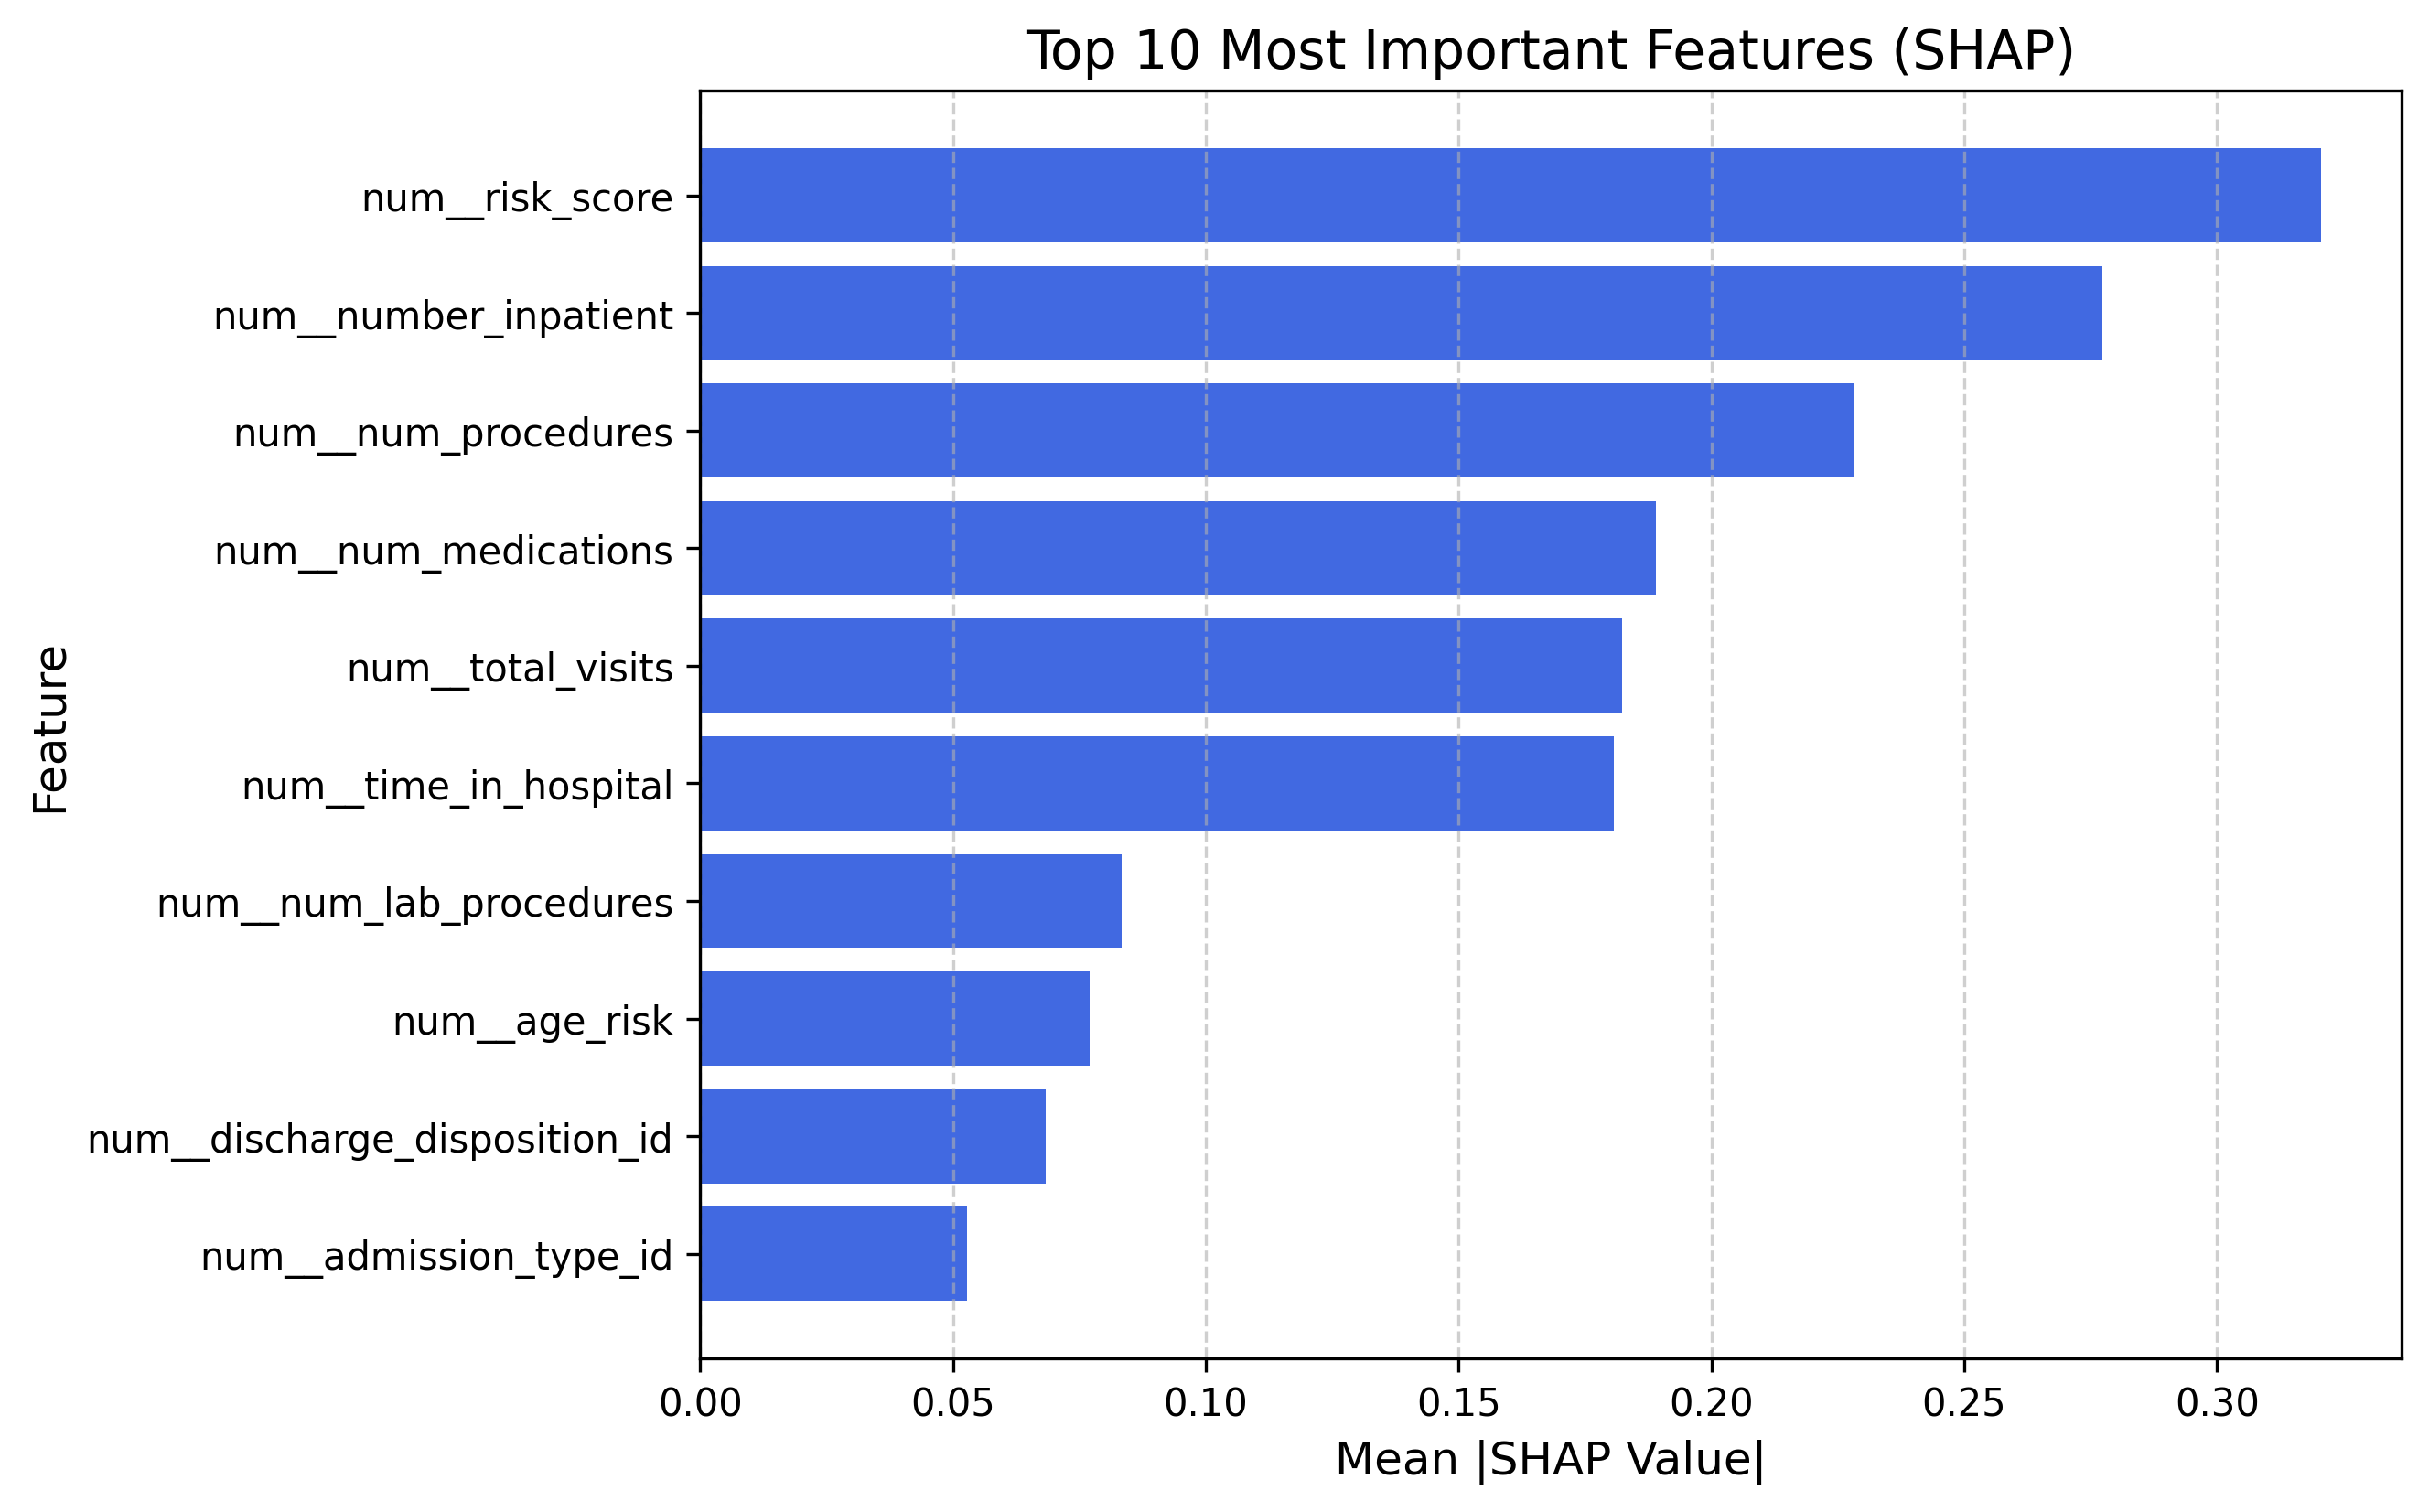

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract preprocessor and XGBoost model
preprocessor = xgboost_uncalib.named_steps['preprocessor']
xgb_model = xgboost_uncalib.named_steps['xgboost']

# Transform test data
X_test_transformed = preprocessor.transform(X_test)

# 🔹 Convert sparse matrix (if applicable) to dense NumPy array
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# 🔹 Extract feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# 🔹 Convert transformed data back to a DataFrame with feature names
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Select background data for SHAP (use a small subset for efficiency)
X_background = X_test_transformed_df.iloc[:100]  # Adjust size if needed

# Initialize TreeExplainer for fast SHAP calculations
explainer = shap.TreeExplainer(xgb_model, data=X_background)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed_df)

# 🔹 Compute mean absolute SHAP values for feature importance
shap_importance = np.abs(shap_values).mean(axis=0)

# 🔹 Create a DataFrame of feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Importance': shap_importance})

# 🔹 Select top 10 most important features
top_10_features = feature_importance_df.sort_values(by="SHAP Importance", ascending=False).head(10)

# 🔹 Plot Top 10 SHAP Feature Importance
plt.figure(figsize=(8, 6), dpi=300)  # High-resolution figure
plt.barh(top_10_features['Feature'][::-1], top_10_features['SHAP Importance'][::-1], color='royalblue')
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (SHAP)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()